## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.007092444
RMSE of after m1 0.007848197
RMSE of after m3 0.08242697
RMSE of after m4 0.08292212
RMSE of after m0 0.0072186105
RMSE of after m1 0.057978842
RMSE of after m3 0.14106181
RMSE of after m4 0.14342928
RMSE of after m0 0.010859054
RMSE of after m1 0.032674108
RMSE of after m3 0.12043043
RMSE of after m4 0.11898567
RMSE of after m0 0.011451844
RMSE of after m1 0.0146057615
RMSE of after m3 0.09147672
RMSE of after m4 0.09161396
RMSE of after m0 0.008204393
RMSE of after m1 0.009301169
RMSE of after m3 0.025273785
RMSE of after m4 0.025726808
RMSE of after m0 0.0072264583
RMSE of after m1 0.0074025407
RMSE of after m3 0.016191827
RMSE of after m4 0.016423672
RMSE of after m0 0.0072240196
RMSE of after m1 0.007011356
RMSE of after m3 0.018599892
RMSE of after m4 0.017872406
RMSE of after m0 0.0071291677
RMSE of after m1 0.0056008175
RMSE of after m3 0.0173955
RMSE of after m4 0.01679748
RMSE of after m0 0.0065425863
RMSE of after m1 0.0063338405
RMSE of after m3

RMSE of after m1 0.011306409
RMSE of after m3 0.04565617
RMSE of after m4 0.045977306
RMSE of after m0 0.007909483
RMSE of after m1 0.012488278
RMSE of after m3 0.04429783
RMSE of after m4 0.043310806
RMSE of after m0 0.0074387947
RMSE of after m1 0.011926008
RMSE of after m3 0.015017784
RMSE of after m4 0.01634372
RMSE of after m0 0.012493471
RMSE of after m1 0.011683664
RMSE of after m3 0.019646285
RMSE of after m4 0.020441566
RMSE of after m0 0.009262372
RMSE of after m1 0.009808144
RMSE of after m3 0.01936181
RMSE of after m4 0.019785251
RMSE of after m0 0.0072694556
RMSE of after m1 0.013337934
RMSE of after m3 0.017694168
RMSE of after m4 0.017725421
RMSE of after m0 0.019696645
RMSE of after m1 0.025862295
RMSE of after m3 0.18271318
RMSE of after m4 0.17985426
RMSE of after m0 0.006810631
RMSE of after m1 0.00537262
RMSE of after m3 0.026013913
RMSE of after m4 0.0236082
RMSE of after m0 0.008393219
RMSE of after m1 0.0075785005
RMSE of after m3 0.036259726
RMSE of after m4 0.0

RMSE of after m1 0.0072400537
RMSE of after m3 0.062123634
RMSE of after m4 0.060035404
RMSE of after m0 0.006551888
RMSE of after m1 0.006594365
RMSE of after m3 0.02403991
RMSE of after m4 0.027285043
RMSE of after m0 0.0050766515
RMSE of after m1 0.004684315
RMSE of after m3 0.023814403
RMSE of after m4 0.0241141
RMSE of after m0 0.005769321
RMSE of after m1 0.0053742765
RMSE of after m3 0.013327956
RMSE of after m4 0.01437552
RMSE of after m0 0.0065858457
RMSE of after m1 0.0060406774
RMSE of after m3 0.030146748
RMSE of after m4 0.026657438
RMSE of after m0 0.007558891
RMSE of after m1 0.007358554
RMSE of after m3 0.04282237
RMSE of after m4 0.041552633
RMSE of after m0 0.007884771
RMSE of after m1 0.007230666
RMSE of after m3 0.024475593
RMSE of after m4 0.025230458
RMSE of after m0 0.007949768
RMSE of after m1 0.007559384
RMSE of after m3 0.036578353
RMSE of after m4 0.03158224
RMSE of after m0 0.0054294486
RMSE of after m1 0.0050840448
RMSE of after m3 0.041567575
RMSE of after

RMSE of after m1 0.005870194
RMSE of after m3 0.01748359
RMSE of after m4 0.023809714
RMSE of after m0 0.004409076
RMSE of after m1 0.0055695428
RMSE of after m3 0.019673305
RMSE of after m4 0.02082858
RMSE of after m0 0.005823762
RMSE of after m1 0.006359453
RMSE of after m3 0.020409282
RMSE of after m4 0.021745196
RMSE of after m0 0.005285627
RMSE of after m1 0.005154288
RMSE of after m3 0.024097534
RMSE of after m4 0.028827881
RMSE of after m0 0.0052184733
RMSE of after m1 0.0058327382
RMSE of after m3 0.023147937
RMSE of after m4 0.025856623
RMSE of after m0 0.006406288
RMSE of after m1 0.007453767
RMSE of after m3 0.019998396
RMSE of after m4 0.019962631
RMSE of after m0 0.005448086
RMSE of after m1 0.006562077
RMSE of after m3 0.021041343
RMSE of after m4 0.022925459
RMSE of after m0 0.0075814105
RMSE of after m1 0.008215617
RMSE of after m3 0.029494531
RMSE of after m4 0.02686233
RMSE of after m0 0.008304131
RMSE of after m1 0.008464505
RMSE of after m3 0.04207624
RMSE of after 

RMSE of after m1 0.0056592906
RMSE of after m3 0.038293052
RMSE of after m4 0.033624467
RMSE of after m0 0.010523418
RMSE of after m1 0.010951759
RMSE of after m3 0.069900475
RMSE of after m4 0.050304715
RMSE of after m0 0.0116001945
RMSE of after m1 0.012164375
RMSE of after m3 0.07863828
RMSE of after m4 0.059263818
RMSE of after m0 0.009479248
RMSE of after m1 0.009761014
RMSE of after m3 0.08323101
RMSE of after m4 0.08218449
RMSE of after m0 0.007447904
RMSE of after m1 0.0077345683
RMSE of after m3 0.04505973
RMSE of after m4 0.042943396
RMSE of after m0 0.0054185353
RMSE of after m1 0.005577069
RMSE of after m3 0.029929744
RMSE of after m4 0.02078883
RMSE of after m0 0.0060019544
RMSE of after m1 0.005782411
RMSE of after m3 0.05397965
RMSE of after m4 0.047471438
RMSE of after m0 0.0061904592
RMSE of after m1 0.0057847183
RMSE of after m3 0.032098982
RMSE of after m4 0.02729078
RMSE of after m0 0.0072086304
RMSE of after m1 0.0068863975
RMSE of after m3 0.04925139
RMSE of after

RMSE of after m1 0.0083334055
RMSE of after m3 0.020706844
RMSE of after m4 0.020137047
RMSE of after m0 0.0074645295
RMSE of after m1 0.008102784
RMSE of after m3 0.015664497
RMSE of after m4 0.015143096
RMSE of after m0 0.007393244
RMSE of after m1 0.007999453
RMSE of after m3 0.019989818
RMSE of after m4 0.021609152
RMSE of after m0 0.007715831
RMSE of after m1 0.00952135
RMSE of after m3 0.017092653
RMSE of after m4 0.018011179
RMSE of after m0 0.010060858
RMSE of after m1 0.012553225
RMSE of after m3 0.029199688
RMSE of after m4 0.028769124
RMSE of after m0 0.013329524
RMSE of after m1 0.018723382
RMSE of after m3 0.22000001
RMSE of after m4 0.21086417
RMSE of after m0 0.0061840895
RMSE of after m1 0.039108265
RMSE of after m3 0.12346713
RMSE of after m4 0.12675859
RMSE of after m0 0.00533196
RMSE of after m1 0.008032906
RMSE of after m3 0.027941274
RMSE of after m4 0.029497355
RMSE of after m0 0.00514703
RMSE of after m1 0.007551851
RMSE of after m3 0.020749746
RMSE of after m4 0

RMSE of after m1 0.0066801296
RMSE of after m3 0.021775259
RMSE of after m4 0.02248478
RMSE of after m0 0.0074346857
RMSE of after m1 0.0053035533
RMSE of after m3 0.014384059
RMSE of after m4 0.015687773
RMSE of after m0 0.014981628
RMSE of after m1 0.008171103
RMSE of after m3 0.04839868
RMSE of after m4 0.046199717
RMSE of after m0 0.015566612
RMSE of after m1 0.009156093
RMSE of after m3 0.016841121
RMSE of after m4 0.018050095
RMSE of after m0 0.022280756
RMSE of after m1 0.015035897
RMSE of after m3 0.02173109
RMSE of after m4 0.022472056
RMSE of after m0 0.015668234
RMSE of after m1 0.01137475
RMSE of after m3 0.018134542
RMSE of after m4 0.01899337
RMSE of after m0 0.013531613
RMSE of after m1 0.010496954
RMSE of after m3 0.01908492
RMSE of after m4 0.019886415
RMSE of after m0 0.01532398
RMSE of after m1 0.012085545
RMSE of after m3 0.017273221
RMSE of after m4 0.018837346
RMSE of after m0 0.011034662
RMSE of after m1 0.00916547
RMSE of after m3 0.01736104
RMSE of after m4 0.0

RMSE of after m1 0.009305861
RMSE of after m3 0.0138871595
RMSE of after m4 0.015152826
RMSE of after m0 0.012873815
RMSE of after m1 0.0076690596
RMSE of after m3 0.014160639
RMSE of after m4 0.015023941
RMSE of after m0 0.010669863
RMSE of after m1 0.008590032
RMSE of after m3 0.018967526
RMSE of after m4 0.018799761
RMSE of after m0 0.010301056
RMSE of after m1 0.008942747
RMSE of after m3 0.028927736
RMSE of after m4 0.02806056
RMSE of after m0 0.008476511
RMSE of after m1 0.008758014
RMSE of after m3 0.020569926
RMSE of after m4 0.020828646
RMSE of after m0 0.00851643
RMSE of after m1 0.008246452
RMSE of after m3 0.013727621
RMSE of after m4 0.014172088
RMSE of after m0 0.007885327
RMSE of after m1 0.007801
RMSE of after m3 0.014798102
RMSE of after m4 0.016060276
RMSE of after m0 0.007546312
RMSE of after m1 0.008195697
RMSE of after m3 0.016124917
RMSE of after m4 0.017451052
RMSE of after m0 0.00800014
RMSE of after m1 0.0076145893
RMSE of after m3 0.0186575
RMSE of after m4 0.

RMSE of after m0 0.005312172
RMSE of after m1 0.0054718778
RMSE of after m3 0.03769546
RMSE of after m4 0.03518761
RMSE of after m0 0.0051553245
RMSE of after m1 0.0051859873
RMSE of after m3 0.05157471
RMSE of after m4 0.05105707
RMSE of after m0 0.0052206647
RMSE of after m1 0.0052308827
RMSE of after m3 0.027901763
RMSE of after m4 0.029978024
RMSE of after m0 0.011139104
RMSE of after m1 0.010207501
RMSE of after m3 0.08584563
RMSE of after m4 0.08832971
RMSE of after m0 0.010084876
RMSE of after m1 0.009651776
RMSE of after m3 0.033332657
RMSE of after m4 0.027400944
RMSE of after m0 0.0067895753
RMSE of after m1 0.0065767835
RMSE of after m3 0.02901106
RMSE of after m4 0.02561943
RMSE of after m0 0.0049097785
RMSE of after m1 0.0048139794
RMSE of after m3 0.019571504
RMSE of after m4 0.017207382
RMSE of after m0 0.004281961
RMSE of after m1 0.0043317173
RMSE of after m3 0.029463325
RMSE of after m4 0.021091707
RMSE of after m0 0.005515422
RMSE of after m1 0.0055323737
RMSE of aft

RMSE of after m4 0.027331421
RMSE of after m0 0.009108257
RMSE of after m1 0.008717034
RMSE of after m3 0.046852008
RMSE of after m4 0.04383593
RMSE of after m0 0.011167539
RMSE of after m1 0.010224112
RMSE of after m3 0.07999293
RMSE of after m4 0.07143933
RMSE of after m0 0.005643523
RMSE of after m1 0.005287798
RMSE of after m3 0.028298436
RMSE of after m4 0.03238623
RMSE of after m0 0.0041646115
RMSE of after m1 0.004557753
RMSE of after m3 0.023041267
RMSE of after m4 0.01997839
RMSE of after m0 0.0054685855
RMSE of after m1 0.00536384
RMSE of after m3 0.022599192
RMSE of after m4 0.018947044
RMSE of after m0 0.006215734
RMSE of after m1 0.0066977227
RMSE of after m3 0.0127789555
RMSE of after m4 0.016574984
RMSE of after m0 0.005866884
RMSE of after m1 0.0060681067
RMSE of after m3 0.021251215
RMSE of after m4 0.02021152
RMSE of after m0 0.0046911817
RMSE of after m1 0.004734665
RMSE of after m3 0.031667262
RMSE of after m4 0.028145012
RMSE of after m0 0.00562927
RMSE of after m1

RMSE of after m0 0.008098043
RMSE of after m1 0.008041998
RMSE of after m3 0.032773662
RMSE of after m4 0.02731826
RMSE of after m0 0.0071104434
RMSE of after m1 0.007391015
RMSE of after m3 0.06068899
RMSE of after m4 0.050156683
RMSE of after m0 0.0072994353
RMSE of after m1 0.0074438197
RMSE of after m3 0.043203793
RMSE of after m4 0.04012125
RMSE of after m0 0.004804949
RMSE of after m1 0.005208934
RMSE of after m3 0.017512735
RMSE of after m4 0.022614269
RMSE of after m0 0.004973768
RMSE of after m1 0.005435607
RMSE of after m3 0.03701456
RMSE of after m4 0.028917786
RMSE of after m0 0.008242609
RMSE of after m1 0.008503134
RMSE of after m3 0.0174417
RMSE of after m4 0.027033018
RMSE of after m0 0.0062702135
RMSE of after m1 0.0065716375
RMSE of after m3 0.020588044
RMSE of after m4 0.028421097
RMSE of after m0 0.005587537
RMSE of after m1 0.005855055
RMSE of after m3 0.017601132
RMSE of after m4 0.017129587
RMSE of after m0 0.011011567
RMSE of after m1 0.011237958
RMSE of after m

RMSE of after m4 0.023787813
RMSE of after m0 0.0049140775
RMSE of after m1 0.005566582
RMSE of after m3 0.018614748
RMSE of after m4 0.0195746
RMSE of after m0 0.004859799
RMSE of after m1 0.0057355203
RMSE of after m3 0.018475577
RMSE of after m4 0.019420361
RMSE of after m0 0.0051279115
RMSE of after m1 0.0058439947
RMSE of after m3 0.040709037
RMSE of after m4 0.041115306
RMSE of after m0 0.0058272467
RMSE of after m1 0.0062235463
RMSE of after m3 0.016308395
RMSE of after m4 0.016982878
RMSE of after m0 0.0075077773
RMSE of after m1 0.0074225655
RMSE of after m3 0.011374315
RMSE of after m4 0.012109283
RMSE of after m0 0.0074673225
RMSE of after m1 0.007914925
RMSE of after m3 0.021695845
RMSE of after m4 0.019728657
RMSE of after m0 0.009007998
RMSE of after m1 0.008262219
RMSE of after m3 0.012856994
RMSE of after m4 0.01144632
RMSE of after m0 0.010115987
RMSE of after m1 0.006609216
RMSE of after m3 0.010666365
RMSE of after m4 0.009987809
RMSE of after m0 0.008786567
RMSE of 

RMSE of after m1 0.007870147
RMSE of after m3 0.0137815
RMSE of after m4 0.015756061
RMSE of after m0 0.018233277
RMSE of after m1 0.0086680185
RMSE of after m3 0.014832948
RMSE of after m4 0.016749404
RMSE of after m0 0.018219512
RMSE of after m1 0.008981031
RMSE of after m3 0.016181188
RMSE of after m4 0.01841247
RMSE of after m0 0.015811058
RMSE of after m1 0.008244015
RMSE of after m3 0.018909372
RMSE of after m4 0.021210816
RMSE of after m0 0.0108864885
RMSE of after m1 0.007881355
RMSE of after m3 0.016651982
RMSE of after m4 0.018913716
RMSE of after m0 0.017930208
RMSE of after m1 0.00875397
RMSE of after m3 0.013243929
RMSE of after m4 0.015227024
RMSE of after m0 0.019524574
RMSE of after m1 0.0086235525
RMSE of after m3 0.013704421
RMSE of after m4 0.016049242
RMSE of after m0 0.018804085
RMSE of after m1 0.009061993
RMSE of after m3 0.039286494
RMSE of after m4 0.040401183
RMSE of after m0 0.016058644
RMSE of after m1 0.008916308
RMSE of after m3 0.0270072
RMSE of after m4 

RMSE of after m0 0.00739501
RMSE of after m1 0.010149212
RMSE of after m3 0.018993497
RMSE of after m4 0.019979073
RMSE of after m0 0.008379524
RMSE of after m1 0.010051467
RMSE of after m3 0.026640734
RMSE of after m4 0.027235577
RMSE of after m0 0.0054063303
RMSE of after m1 0.008577226
RMSE of after m3 0.016791938
RMSE of after m4 0.017595278
RMSE of after m0 0.0071134265
RMSE of after m1 0.0094339
RMSE of after m3 0.02047409
RMSE of after m4 0.020813402
RMSE of after m0 0.009163791
RMSE of after m1 0.010418072
RMSE of after m3 0.013747895
RMSE of after m4 0.015018456
RMSE of after m0 0.012610616
RMSE of after m1 0.0116604455
RMSE of after m3 0.018261356
RMSE of after m4 0.018683769
RMSE of after m0 0.006773913
RMSE of after m1 0.008428458
RMSE of after m3 0.027816728
RMSE of after m4 0.028089073
RMSE of after m0 0.006918703
RMSE of after m1 0.010031347
RMSE of after m3 0.015420268
RMSE of after m4 0.015375609
RMSE of after m0 0.0063289884
RMSE of after m1 0.009889824
RMSE of after 

RMSE of after m4 0.014371207
RMSE of after m0 0.0053116567
RMSE of after m1 0.0055223024
RMSE of after m3 0.04757738
RMSE of after m4 0.048043553
RMSE of after m0 0.010918909
RMSE of after m1 0.009862691
RMSE of after m3 0.05174739
RMSE of after m4 0.05218732
RMSE of after m0 0.005103883
RMSE of after m1 0.0049320096
RMSE of after m3 0.02130792
RMSE of after m4 0.021361802
RMSE of after m0 0.0048384634
RMSE of after m1 0.0045457147
RMSE of after m3 0.054680943
RMSE of after m4 0.055942558
RMSE of after m0 0.009993622
RMSE of after m1 0.010173635
RMSE of after m3 0.04042517
RMSE of after m4 0.043578804
RMSE of after m0 0.005345967
RMSE of after m1 0.0057372404
RMSE of after m3 0.021115605
RMSE of after m4 0.019818818
RMSE of after m0 0.007778136
RMSE of after m1 0.008205604
RMSE of after m3 0.020057604
RMSE of after m4 0.026586195
RMSE of after m0 0.005699145
RMSE of after m1 0.0062098876
RMSE of after m3 0.01517332
RMSE of after m4 0.013774598
RMSE of after m0 0.0072149998
RMSE of afte

RMSE of after m1 0.005880988
RMSE of after m3 0.019222314
RMSE of after m4 0.018657561
RMSE of after m0 0.007302803
RMSE of after m1 0.006915959
RMSE of after m3 0.02910072
RMSE of after m4 0.023995608
RMSE of after m0 0.0050436
RMSE of after m1 0.0050890786
RMSE of after m3 0.019217229
RMSE of after m4 0.017381907
RMSE of after m0 0.006904143
RMSE of after m1 0.0071939435
RMSE of after m3 0.025395043
RMSE of after m4 0.0319131
RMSE of after m0 0.0047833784
RMSE of after m1 0.005190932
RMSE of after m3 0.012898456
RMSE of after m4 0.015130553
RMSE of after m0 0.0057312404
RMSE of after m1 0.0058585126
RMSE of after m3 0.02571886
RMSE of after m4 0.02449044
RMSE of after m0 0.005597703
RMSE of after m1 0.0059624407
RMSE of after m3 0.014619674
RMSE of after m4 0.015607136
RMSE of after m0 0.0049243597
RMSE of after m1 0.004953641
RMSE of after m3 0.029351953
RMSE of after m4 0.026677478
RMSE of after m0 0.0049631796
RMSE of after m1 0.005210352
RMSE of after m3 0.01685476
RMSE of after 

RMSE of after m0 0.0038388353
RMSE of after m1 0.004232216
RMSE of after m3 0.01330783
RMSE of after m4 0.016357865
RMSE of after m0 0.0039523407
RMSE of after m1 0.0045619835
RMSE of after m3 0.03187409
RMSE of after m4 0.031234508
RMSE of after m0 0.0048155785
RMSE of after m1 0.0053595076
RMSE of after m3 0.03650133
RMSE of after m4 0.032219607
RMSE of after m0 0.0058066417
RMSE of after m1 0.0056438693
RMSE of after m3 0.02573193
RMSE of after m4 0.021337684
RMSE of after m0 0.005079879
RMSE of after m1 0.004972282
RMSE of after m3 0.051234614
RMSE of after m4 0.03941951
RMSE of after m0 0.004524367
RMSE of after m1 0.0044402713
RMSE of after m3 0.046865337
RMSE of after m4 0.036547307
RMSE of after m0 0.0044425074
RMSE of after m1 0.004284928
RMSE of after m3 0.030298997
RMSE of after m4 0.018336948
RMSE of after m0 0.005889931
RMSE of after m1 0.005547973
RMSE of after m3 0.02635692
RMSE of after m4 0.02009133
RMSE of after m0 0.005031352
RMSE of after m1 0.0046308874
RMSE of aft

RMSE of after m3 0.016663298
RMSE of after m4 0.018743813
RMSE of after m0 0.004764537
RMSE of after m1 0.0072061718
RMSE of after m3 0.016973766
RMSE of after m4 0.018762903
RMSE of after m0 0.005199
RMSE of after m1 0.007009102
RMSE of after m3 0.016632702
RMSE of after m4 0.018540548
RMSE of after m0 0.005833973
RMSE of after m1 0.0076551107
RMSE of after m3 0.035475325
RMSE of after m4 0.036690578
RMSE of after m0 0.0047036037
RMSE of after m1 0.007273862
RMSE of after m3 0.0409397
RMSE of after m4 0.04152785
RMSE of after m0 0.0060401764
RMSE of after m1 0.0067502297
RMSE of after m3 0.012692702
RMSE of after m4 0.015089872
RMSE of after m0 0.005144971
RMSE of after m1 0.006466735
RMSE of after m3 0.020166961
RMSE of after m4 0.022046398
RMSE of after m0 0.0050936216
RMSE of after m1 0.00610565
RMSE of after m3 0.019537462
RMSE of after m4 0.021101741
RMSE of after m0 0.004801331
RMSE of after m1 0.0053091133
RMSE of after m3 0.019191217
RMSE of after m4 0.020875273
RMSE of after 

RMSE of after m1 0.00778239
RMSE of after m3 0.013123956
RMSE of after m4 0.015285514
RMSE of after m0 0.01871701
RMSE of after m1 0.008642089
RMSE of after m3 0.0147493575
RMSE of after m4 0.017078003
RMSE of after m0 0.021837197
RMSE of after m1 0.008760952
RMSE of after m3 0.01459855
RMSE of after m4 0.016363617
RMSE of after m0 0.019148234
RMSE of after m1 0.008770716
RMSE of after m3 0.016299563
RMSE of after m4 0.018433277
RMSE of after m0 0.01758391
RMSE of after m1 0.008799479
RMSE of after m3 0.015578689
RMSE of after m4 0.01719956
RMSE of after m0 0.009325665
RMSE of after m1 0.008387068
RMSE of after m3 0.01999834
RMSE of after m4 0.021500878
RMSE of after m0 0.019653961
RMSE of after m1 0.009152481
RMSE of after m3 0.016715316
RMSE of after m4 0.018839192
RMSE of after m0 0.019984622
RMSE of after m1 0.009465995
RMSE of after m3 0.016059002
RMSE of after m4 0.018302657
RMSE of after m0 0.021937938
RMSE of after m1 0.009384376
RMSE of after m3 0.017082168
RMSE of after m4 0.

RMSE of after m1 0.005708587
RMSE of after m3 0.023151139
RMSE of after m4 0.021558538
RMSE of after m0 0.004888202
RMSE of after m1 0.0040250295
RMSE of after m3 0.0143439
RMSE of after m4 0.0119141275
RMSE of after m0 0.005120761
RMSE of after m1 0.003688392
RMSE of after m3 0.024608038
RMSE of after m4 0.030267136
RMSE of after m0 0.004597616
RMSE of after m1 0.0033130823
RMSE of after m3 0.022988487
RMSE of after m4 0.024972282
RMSE of after m0 0.0051102336
RMSE of after m1 0.0039295442
RMSE of after m3 0.014126954
RMSE of after m4 0.012196424
RMSE of after m0 0.0068153515
RMSE of after m1 0.0059171254
RMSE of after m3 0.05331417
RMSE of after m4 0.046670724
RMSE of after m0 0.010802403
RMSE of after m1 0.010644287
RMSE of after m3 0.05387661
RMSE of after m4 0.04671128
RMSE of after m0 0.0049951063
RMSE of after m1 0.004676619
RMSE of after m3 0.021526612
RMSE of after m4 0.021621097
RMSE of after m0 0.005171089
RMSE of after m1 0.0045236633
RMSE of after m3 0.048300818
RMSE of af

RMSE of after m1 0.0081804665
RMSE of after m3 0.03990745
RMSE of after m4 0.038097966
RMSE of after m0 0.005965058
RMSE of after m1 0.0061554117
RMSE of after m3 0.022549363
RMSE of after m4 0.021146761
RMSE of after m0 0.005449788
RMSE of after m1 0.005531646
RMSE of after m3 0.025278438
RMSE of after m4 0.025847873
RMSE of after m0 0.004161756
RMSE of after m1 0.004688828
RMSE of after m3 0.018188171
RMSE of after m4 0.017543208
RMSE of after m0 0.0044256398
RMSE of after m1 0.004843245
RMSE of after m3 0.017030448
RMSE of after m4 0.01619828
RMSE of after m0 0.005294775
RMSE of after m1 0.0057809
RMSE of after m3 0.020128539
RMSE of after m4 0.021880861
RMSE of after m0 0.0059269643
RMSE of after m1 0.006847434
RMSE of after m3 0.01346532
RMSE of after m4 0.014095523
RMSE of after m0 0.007531397
RMSE of after m1 0.00852661
RMSE of after m3 0.017485732
RMSE of after m4 0.026345026
RMSE of after m0 0.0070538386
RMSE of after m1 0.00730332
RMSE of after m3 0.030128973
RMSE of after m4

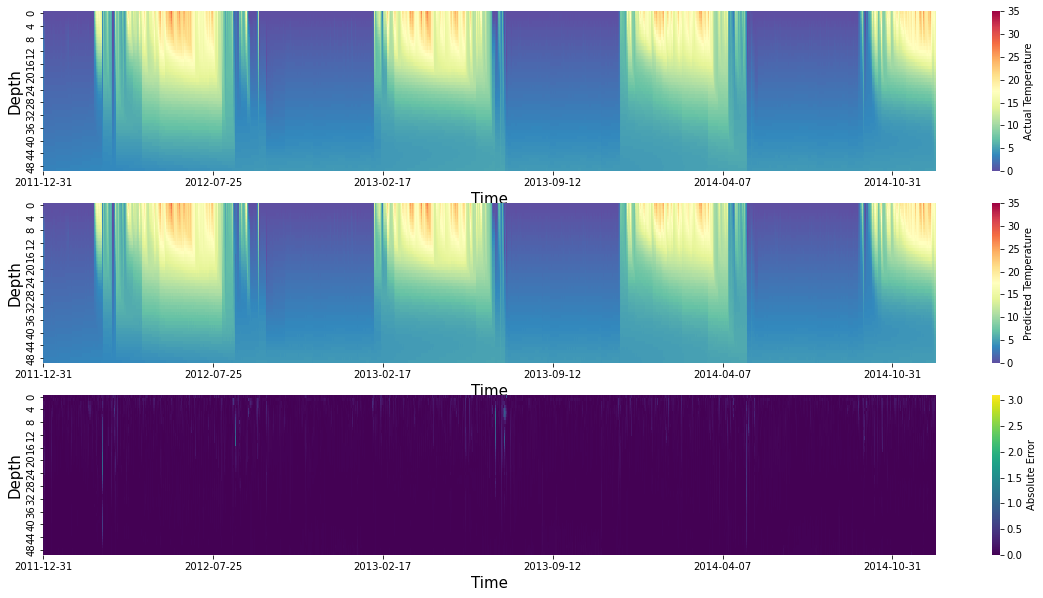

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

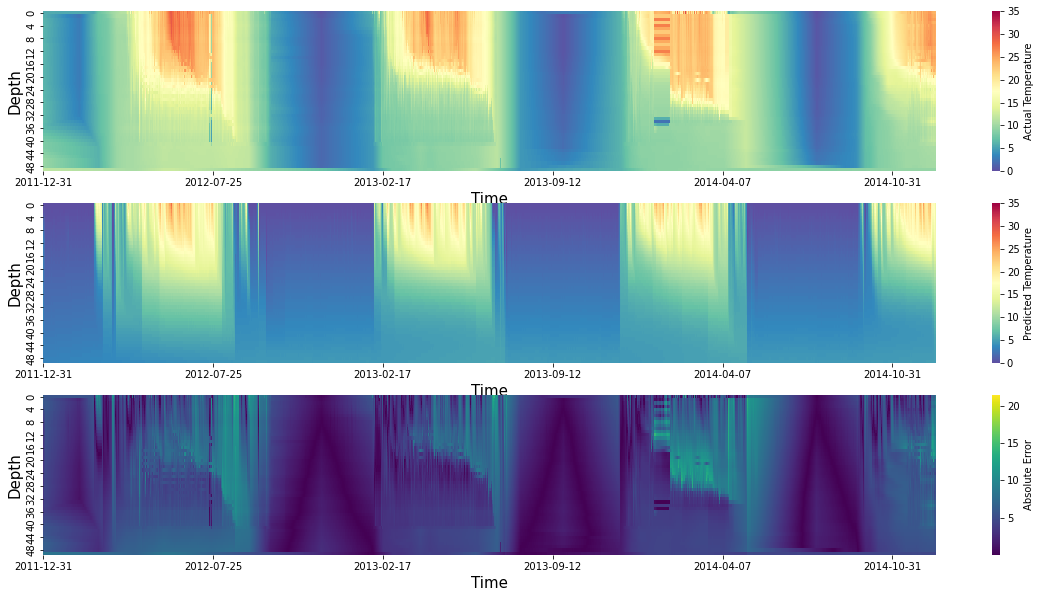

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.004135971
RMSE of after m1 0.004479291
RMSE of after m3 0.016186077
RMSE of after m4 0.015806494
RMSE of after m0 0.0061636027
RMSE of after m1 0.006421405
RMSE of after m3 0.017990427
RMSE of after m4 0.022091104
RMSE of after m0 0.0062802625
RMSE of after m1 0.006737346
RMSE of after m3 0.011452788
RMSE of after m4 0.015599561
RMSE of after m0 0.0054500657
RMSE of after m1 0.005826562
RMSE of after m3 0.016994745
RMSE of after m4 0.016447876
RMSE of after m0 0.0046294285
RMSE of after m1 0.0050573465
RMSE of after m3 0.019389335
RMSE of after m4 0.017191267
RMSE of after m0 0.005027943
RMSE of after m1 0.005173076
RMSE of after m3 0.029804477
RMSE of after m4 0.02650198
RMSE of after m0 0.00583606
RMSE of after m1 0.0057957144
RMSE of after m3 0.038443286
RMSE of after m4 0.03492506
RMSE of after m0 0.006651819
RMSE of after m1 0.006739272
RMSE of after m3 0.023769505
RMSE of after m4 0.021273416
RMSE of after m0 0.0053638075
RMSE of after m1 0.0055737193
RMSE of a

RMSE of after m4 0.18129733
RMSE of after m0 0.005331196
RMSE of after m1 0.007029772
RMSE of after m3 0.12025431
RMSE of after m4 0.1185917
RMSE of after m0 0.0058242087
RMSE of after m1 0.006974829
RMSE of after m3 0.13071682
RMSE of after m4 0.1239802
RMSE of after m0 0.014171392
RMSE of after m1 0.016342279
RMSE of after m3 0.35324323
RMSE of after m4 0.34213266
RMSE of after m0 0.0058520404
RMSE of after m1 0.0057437913
RMSE of after m3 0.055583917
RMSE of after m4 0.043811403
RMSE of after m0 0.008196163
RMSE of after m1 0.008358146
RMSE of after m3 0.038491786
RMSE of after m4 0.04800829
RMSE of after m0 0.005928665
RMSE of after m1 0.0067312
RMSE of after m3 0.01956877
RMSE of after m4 0.025836647
RMSE of after m0 0.005710668
RMSE of after m1 0.006592579
RMSE of after m3 0.03894069
RMSE of after m4 0.0279894
RMSE of after m0 0.0074287755
RMSE of after m1 0.007723892
RMSE of after m3 0.0434962
RMSE of after m4 0.044795286
RMSE of after m0 0.007425567
RMSE of after m1 0.008198519

RMSE of after m1 0.008740593
RMSE of after m3 0.02845357
RMSE of after m4 0.030381246
RMSE of after m0 0.005378498
RMSE of after m1 0.008921199
RMSE of after m3 0.02679683
RMSE of after m4 0.027486881
RMSE of after m0 0.0059400043
RMSE of after m1 0.008239523
RMSE of after m3 0.013306986
RMSE of after m4 0.011973906
RMSE of after m0 0.0057237707
RMSE of after m1 0.010102135
RMSE of after m3 0.012190522
RMSE of after m4 0.010615166
RMSE of after m0 0.004977861
RMSE of after m1 0.013627521
RMSE of after m3 0.079109386
RMSE of after m4 0.07829713
RMSE of after m0 0.0069531607
RMSE of after m1 0.02118714
RMSE of after m3 0.040655326
RMSE of after m4 0.04074837
RMSE of after m0 0.006682647
RMSE of after m1 0.020765275
RMSE of after m3 0.022286534
RMSE of after m4 0.0205148
RMSE of after m0 0.0073220157
RMSE of after m1 0.020621847
RMSE of after m3 0.017843423
RMSE of after m4 0.016268017
RMSE of after m0 0.010481503
RMSE of after m1 0.017365063
RMSE of after m3 0.060473774
RMSE of after m4 

RMSE of after m3 0.06644547
RMSE of after m4 0.06659562
RMSE of after m0 0.0070842663
RMSE of after m1 0.008284413
RMSE of after m3 0.12754378
RMSE of after m4 0.12677833
RMSE of after m0 0.008066041
RMSE of after m1 0.008355946
RMSE of after m3 0.09574562
RMSE of after m4 0.09519948
RMSE of after m0 0.0075938124
RMSE of after m1 0.0070891953
RMSE of after m3 0.054060042
RMSE of after m4 0.054608922
RMSE of after m0 0.007455152
RMSE of after m1 0.008456215
RMSE of after m3 0.03272228
RMSE of after m4 0.033566147
RMSE of after m0 0.0072699655
RMSE of after m1 0.0077835014
RMSE of after m3 0.03803712
RMSE of after m4 0.03813779
RMSE of after m0 0.007397886
RMSE of after m1 0.007144992
RMSE of after m3 0.04269776
RMSE of after m4 0.042214822
RMSE of after m0 0.007647038
RMSE of after m1 0.0076865805
RMSE of after m3 0.046493363
RMSE of after m4 0.0458413
RMSE of after m0 0.011959721
RMSE of after m1 0.008347109
RMSE of after m3 0.05513502
RMSE of after m4 0.05340217
RMSE of after m0 0.010

RMSE of after m0 0.00505991
RMSE of after m1 0.004691476
RMSE of after m3 0.023897702
RMSE of after m4 0.01647377
RMSE of after m0 0.0065949904
RMSE of after m1 0.0062334733
RMSE of after m3 0.04288607
RMSE of after m4 0.037124045
RMSE of after m0 0.0043288944
RMSE of after m1 0.00402723
RMSE of after m3 0.027235301
RMSE of after m4 0.025270265
RMSE of after m0 0.0055769547
RMSE of after m1 0.0049692155
RMSE of after m3 0.016313583
RMSE of after m4 0.016865062
RMSE of after m0 0.0049130553
RMSE of after m1 0.0045781294
RMSE of after m3 0.0143844485
RMSE of after m4 0.012210596
RMSE of after m0 0.0051020347
RMSE of after m1 0.0048348554
RMSE of after m3 0.014179721
RMSE of after m4 0.014871897
RMSE of after m0 0.004474357
RMSE of after m1 0.0044829296
RMSE of after m3 0.018292092
RMSE of after m4 0.016490104
RMSE of after m0 0.004477948
RMSE of after m1 0.0045330455
RMSE of after m3 0.020817807
RMSE of after m4 0.019542668
RMSE of after m0 0.0045812996
RMSE of after m1 0.004257297
RMSE 

RMSE of after m3 0.017297724
RMSE of after m4 0.020053992
RMSE of after m0 0.007270827
RMSE of after m1 0.007633841
RMSE of after m3 0.021613978
RMSE of after m4 0.017511029
RMSE of after m0 0.0068257274
RMSE of after m1 0.007543216
RMSE of after m3 0.030798221
RMSE of after m4 0.027112983
RMSE of after m0 0.006305584
RMSE of after m1 0.0067609465
RMSE of after m3 0.033204947
RMSE of after m4 0.026695652
RMSE of after m0 0.010190639
RMSE of after m1 0.010359592
RMSE of after m3 0.034247458
RMSE of after m4 0.031726845
RMSE of after m0 0.008232693
RMSE of after m1 0.008188131
RMSE of after m3 0.044833697
RMSE of after m4 0.039338227
RMSE of after m0 0.0057989443
RMSE of after m1 0.006318994
RMSE of after m3 0.023647858
RMSE of after m4 0.01969677
RMSE of after m0 0.005360461
RMSE of after m1 0.005816862
RMSE of after m3 0.028285883
RMSE of after m4 0.023784937
RMSE of after m0 0.006333834
RMSE of after m1 0.006645069
RMSE of after m3 0.028220518
RMSE of after m4 0.024132855
RMSE of afte

RMSE of after m0 0.0062341453
RMSE of after m1 0.006465185
RMSE of after m3 0.05646539
RMSE of after m4 0.052367467
RMSE of after m0 0.005523352
RMSE of after m1 0.00585093
RMSE of after m3 0.02555377
RMSE of after m4 0.020079946
RMSE of after m0 0.006256381
RMSE of after m1 0.006607064
RMSE of after m3 0.013363429
RMSE of after m4 0.021073481
RMSE of after m0 0.0044068173
RMSE of after m1 0.004796416
RMSE of after m3 0.0173342
RMSE of after m4 0.021237034
RMSE of after m0 0.00404284
RMSE of after m1 0.004325229
RMSE of after m3 0.015893627
RMSE of after m4 0.017966013
RMSE of after m0 0.003891666
RMSE of after m1 0.004067061
RMSE of after m3 0.019798666
RMSE of after m4 0.018082485
RMSE of after m0 0.0055681947
RMSE of after m1 0.0059579834
RMSE of after m3 0.019215269
RMSE of after m4 0.02464255
RMSE of after m0 0.005343205
RMSE of after m1 0.005835408
RMSE of after m3 0.019310413
RMSE of after m4 0.024522483
RMSE of after m0 0.004960038
RMSE of after m1 0.005317908
RMSE of after m3 

RMSE of after m1 0.011436781
RMSE of after m3 0.0155512085
RMSE of after m4 0.01570645
RMSE of after m0 0.007603241
RMSE of after m1 0.012022584
RMSE of after m3 0.019327378
RMSE of after m4 0.01876706
RMSE of after m0 0.0057699527
RMSE of after m1 0.009234888
RMSE of after m3 0.013170397
RMSE of after m4 0.012811989
RMSE of after m0 0.006023074
RMSE of after m1 0.008647385
RMSE of after m3 0.011031482
RMSE of after m4 0.011633704
RMSE of after m0 0.005254507
RMSE of after m1 0.0074097444
RMSE of after m3 0.015300894
RMSE of after m4 0.01733096
RMSE of after m0 0.0038808098
RMSE of after m1 0.009802767
RMSE of after m3 0.01792524
RMSE of after m4 0.021262364
RMSE of after m0 0.0056246663
RMSE of after m1 0.012837462
RMSE of after m3 0.017477557
RMSE of after m4 0.020047553
RMSE of after m0 0.008836703
RMSE of after m1 0.015154156
RMSE of after m3 0.018284293
RMSE of after m4 0.021123819
RMSE of after m0 0.012733677
RMSE of after m1 0.016994247
RMSE of after m3 0.01664713
RMSE of after 

RMSE of after m1 0.007554571
RMSE of after m3 0.056861747
RMSE of after m4 0.0563714
RMSE of after m0 0.013883737
RMSE of after m1 0.007487997
RMSE of after m3 0.029870668
RMSE of after m4 0.029635169
RMSE of after m0 0.0140183205
RMSE of after m1 0.008392922
RMSE of after m3 0.020661233
RMSE of after m4 0.021636952
RMSE of after m0 0.010434541
RMSE of after m1 0.007833915
RMSE of after m3 0.028192341
RMSE of after m4 0.027633585
RMSE of after m0 0.0074602608
RMSE of after m1 0.006984783
RMSE of after m3 0.015856035
RMSE of after m4 0.018660363
RMSE of after m0 0.0071011395
RMSE of after m1 0.0070401533
RMSE of after m3 0.022862462
RMSE of after m4 0.024057891
RMSE of after m0 0.0075366036
RMSE of after m1 0.0076451
RMSE of after m3 0.051774457
RMSE of after m4 0.051112723
RMSE of after m0 0.006832888
RMSE of after m1 0.00757572
RMSE of after m3 0.023249203
RMSE of after m4 0.023131136
RMSE of after m0 0.00715921
RMSE of after m1 0.008287172
RMSE of after m3 0.020561537
RMSE of after m

RMSE of after m1 0.0068918956
RMSE of after m3 0.034502618
RMSE of after m4 0.0352811
RMSE of after m0 0.008883894
RMSE of after m1 0.008772364
RMSE of after m3 0.059745047
RMSE of after m4 0.05955173
RMSE of after m0 0.0066551287
RMSE of after m1 0.006481599
RMSE of after m3 0.02935447
RMSE of after m4 0.024678964
RMSE of after m0 0.0042056334
RMSE of after m1 0.0042869397
RMSE of after m3 0.027587082
RMSE of after m4 0.020927107
RMSE of after m0 0.004618452
RMSE of after m1 0.004812602
RMSE of after m3 0.022869796
RMSE of after m4 0.01807222
RMSE of after m0 0.009420559
RMSE of after m1 0.00970905
RMSE of after m3 0.05349061
RMSE of after m4 0.058051784
RMSE of after m0 0.00813704
RMSE of after m1 0.008475621
RMSE of after m3 0.03554309
RMSE of after m4 0.041535795
RMSE of after m0 0.011138291
RMSE of after m1 0.010610824
RMSE of after m3 0.049576703
RMSE of after m4 0.05101197
RMSE of after m0 0.009430379
RMSE of after m1 0.009049457
RMSE of after m3 0.0368269
RMSE of after m4 0.032

RMSE of after m4 0.022651616
RMSE of after m0 0.0060238116
RMSE of after m1 0.0062747314
RMSE of after m3 0.025128366
RMSE of after m4 0.02121963
RMSE of after m0 0.006207747
RMSE of after m1 0.006800795
RMSE of after m3 0.01694469
RMSE of after m4 0.018348688
RMSE of after m0 0.0042869826
RMSE of after m1 0.0057690316
RMSE of after m3 0.013807557
RMSE of after m4 0.019384243
RMSE of after m0 0.007258438
RMSE of after m1 0.007335711
RMSE of after m3 0.046394728
RMSE of after m4 0.04418443
RMSE of after m0 0.008444345
RMSE of after m1 0.0082142465
RMSE of after m3 0.06492581
RMSE of after m4 0.06237692
RMSE of after m0 0.005676758
RMSE of after m1 0.0059795147
RMSE of after m3 0.03316154
RMSE of after m4 0.0313884
RMSE of after m0 0.0053314045
RMSE of after m1 0.005763893
RMSE of after m3 0.03064631
RMSE of after m4 0.0323792
RMSE of after m0 0.0059298994
RMSE of after m1 0.006331128
RMSE of after m3 0.018989434
RMSE of after m4 0.018937465
RMSE of after m0 0.008086541
RMSE of after m1 

RMSE of after m1 0.00484645
RMSE of after m3 0.014311025
RMSE of after m4 0.016088217
RMSE of after m0 0.0045429394
RMSE of after m1 0.0047338917
RMSE of after m3 0.012899084
RMSE of after m4 0.01727269
RMSE of after m0 0.0056142714
RMSE of after m1 0.005729059
RMSE of after m3 0.017096993
RMSE of after m4 0.020530682
RMSE of after m0 0.004594331
RMSE of after m1 0.005040472
RMSE of after m3 0.031376306
RMSE of after m4 0.031430915
RMSE of after m0 0.0120321335
RMSE of after m1 0.011375195
RMSE of after m3 0.05952142
RMSE of after m4 0.046660293
RMSE of after m0 0.007633817
RMSE of after m1 0.007284979
RMSE of after m3 0.028300095
RMSE of after m4 0.02542811
RMSE of after m0 0.0059349868
RMSE of after m1 0.0059121842
RMSE of after m3 0.022677844
RMSE of after m4 0.017088471
RMSE of after m0 0.005028839
RMSE of after m1 0.005173245
RMSE of after m3 0.019343767
RMSE of after m4 0.019257635
RMSE of after m0 0.0058028656
RMSE of after m1 0.0059558223
RMSE of after m3 0.032271657
RMSE of af

RMSE of after m3 0.041493982
RMSE of after m4 0.042800948
RMSE of after m0 0.0070129074
RMSE of after m1 0.011506493
RMSE of after m3 0.031617764
RMSE of after m4 0.032482132
RMSE of after m0 0.0061712936
RMSE of after m1 0.008254627
RMSE of after m3 0.023138158
RMSE of after m4 0.024274569
RMSE of after m0 0.006283479
RMSE of after m1 0.0059630214
RMSE of after m3 0.027055113
RMSE of after m4 0.028688755
RMSE of after m0 0.0062547503
RMSE of after m1 0.0074361362
RMSE of after m3 0.022306582
RMSE of after m4 0.02408584
RMSE of after m0 0.005953802
RMSE of after m1 0.005790852
RMSE of after m3 0.021714563
RMSE of after m4 0.022802332
RMSE of after m0 0.009577758
RMSE of after m1 0.010558401
RMSE of after m3 0.015847955
RMSE of after m4 0.016231474
RMSE of after m0 0.008519841
RMSE of after m1 0.0119447
RMSE of after m3 0.024361515
RMSE of after m4 0.026576478
RMSE of after m0 0.006415041
RMSE of after m1 0.008594526
RMSE of after m3 0.01810222
RMSE of after m4 0.020811342
RMSE of after

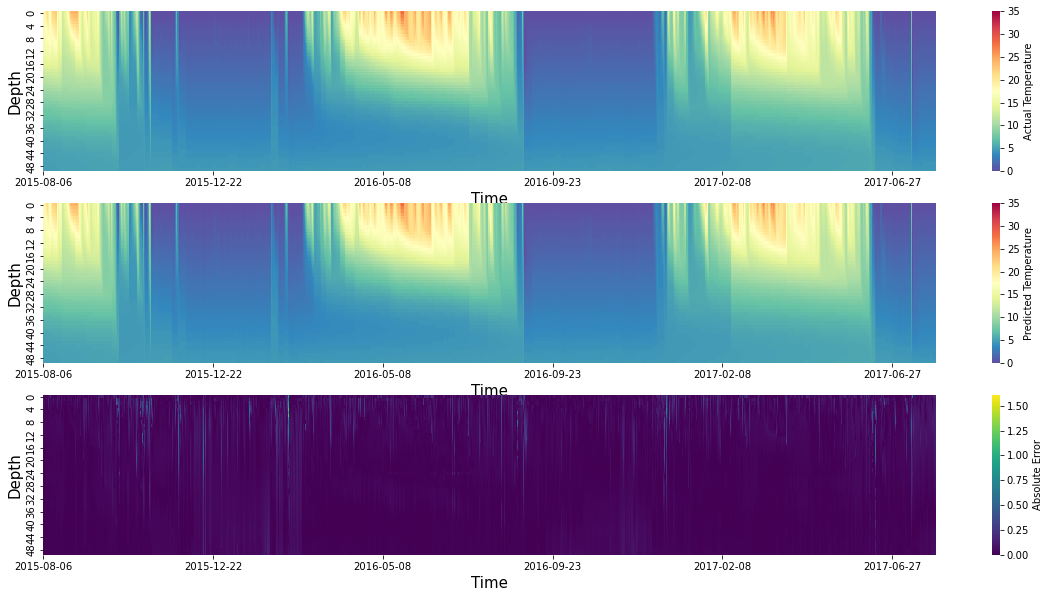

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

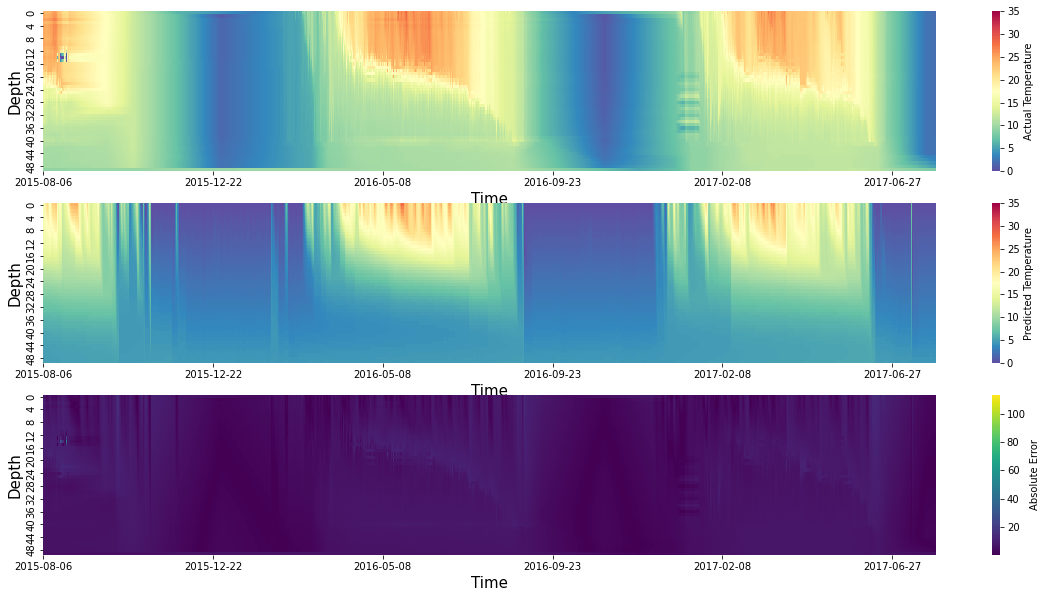

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.044002482140616875, Train L2 Error: 0.0057944492641925464
Test RMSE: 0.05826678537648185, Train L2 Error: 0.007324983395902901


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.015208577187583667, Train L2 Error: 0.002002855682291244
Test RMSE: 0.016331945453217925, Train L2 Error: 0.0020532857040026606


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0073198410576106885, Train L2 Error: 0.0009632675657546159
Test RMSE: 0.019266575643400362, Train L2 Error: 0.002420395383395851


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:07<2:10:19,  7.83s/it]

Epoch : 0, Train_loss: 0.8194493899565705, Loss m0: 3.175268130787494e-06, Loss m1: 0.013057815638125265,  Loss m3: 0.8194493899565705, Loss m4: 3.2287448155684948e-06


  5%|▌         | 51/1000 [06:25<2:01:27,  7.68s/it]

Epoch : 50, Train_loss: 0.1339884578421209, Loss m0: 3.175268130787494e-06, Loss m1: 0.6347226813554773,  Loss m3: 0.1339884578421209, Loss m4: 3.2287448155684948e-06


 10%|█         | 101/1000 [12:45<1:53:55,  7.60s/it]

Epoch : 100, Train_loss: 0.11871539812838407, Loss m0: 3.175268130787494e-06, Loss m1: 0.64161456280408,  Loss m3: 0.11871539812838407, Loss m4: 3.2287448155684948e-06


 15%|█▌        | 151/1000 [19:05<1:47:27,  7.59s/it]

Epoch : 150, Train_loss: 0.10922630143609177, Loss m0: 3.175268130787494e-06, Loss m1: 0.6469310744168622,  Loss m3: 0.10922630143609177, Loss m4: 3.2287448155684948e-06


 20%|██        | 201/1000 [25:25<1:41:24,  7.62s/it]

Epoch : 200, Train_loss: 0.10212287389530467, Loss m0: 3.175268130787494e-06, Loss m1: 0.6520000481576729,  Loss m3: 0.10212287389530467, Loss m4: 3.2287448155684948e-06


 25%|██▌       | 251/1000 [31:46<1:34:45,  7.59s/it]

Epoch : 250, Train_loss: 0.09668117107708994, Loss m0: 3.175268130787494e-06, Loss m1: 0.656592532592213,  Loss m3: 0.09668117107708994, Loss m4: 3.2287448155684948e-06


 30%|███       | 301/1000 [38:07<1:29:04,  7.65s/it]

Epoch : 300, Train_loss: 0.09224717280708244, Loss m0: 3.175268130787494e-06, Loss m1: 0.660348483592659,  Loss m3: 0.09224717280708244, Loss m4: 3.2287448155684948e-06


 35%|███▌      | 351/1000 [44:28<1:22:17,  7.61s/it]

Epoch : 350, Train_loss: 0.08842058535352472, Loss m0: 3.175268130787494e-06, Loss m1: 0.6632154331883683,  Loss m3: 0.08842058535352472, Loss m4: 3.2287448155684948e-06


 40%|████      | 401/1000 [50:48<1:15:49,  7.60s/it]

Epoch : 400, Train_loss: 0.0850787889024984, Loss m0: 3.175268130787494e-06, Loss m1: 0.6653428913102366,  Loss m3: 0.0850787889024984, Loss m4: 3.2287448155684948e-06


 45%|████▌     | 451/1000 [57:08<1:09:23,  7.58s/it]

Epoch : 450, Train_loss: 0.08212551730242293, Loss m0: 3.175268130787494e-06, Loss m1: 0.6669144502478559,  Loss m3: 0.08212551730242293, Loss m4: 3.2287448155684948e-06


 50%|█████     | 501/1000 [1:03:28<1:02:48,  7.55s/it]

Epoch : 500, Train_loss: 0.07948751436886986, Loss m0: 3.175268130787494e-06, Loss m1: 0.6681228258383799,  Loss m3: 0.07948751436886986, Loss m4: 3.2287448155684948e-06


 55%|█████▌    | 551/1000 [1:09:47<57:08,  7.63s/it]  

Epoch : 550, Train_loss: 0.07714598207968831, Loss m0: 3.175268130787494e-06, Loss m1: 0.6691488804276773,  Loss m3: 0.07714598207968831, Loss m4: 3.2287448155684948e-06


 60%|██████    | 601/1000 [1:16:05<50:06,  7.54s/it]

Epoch : 600, Train_loss: 0.07511192466266907, Loss m0: 3.175268130787494e-06, Loss m1: 0.6700942516397728,  Loss m3: 0.07511192466266907, Loss m4: 3.2287448155684948e-06


 65%|██████▌   | 651/1000 [1:22:24<44:04,  7.58s/it]

Epoch : 650, Train_loss: 0.0733627081442629, Loss m0: 3.175268130787494e-06, Loss m1: 0.6709366850802824,  Loss m3: 0.0733627081442629, Loss m4: 3.2287448155684948e-06


 70%|███████   | 701/1000 [1:28:43<37:55,  7.61s/it]

Epoch : 700, Train_loss: 0.07186012221745207, Loss m0: 3.175268130787494e-06, Loss m1: 0.671675516194481,  Loss m3: 0.07186012221745207, Loss m4: 3.2287448155684948e-06


 75%|███████▌  | 751/1000 [1:35:01<31:29,  7.59s/it]

Epoch : 750, Train_loss: 0.07057547320295136, Loss m0: 3.175268130787494e-06, Loss m1: 0.6723446783967344,  Loss m3: 0.07057547320295136, Loss m4: 3.2287448155684948e-06


 80%|████████  | 801/1000 [1:41:21<25:16,  7.62s/it]

Epoch : 800, Train_loss: 0.06948611903184652, Loss m0: 3.175268130787494e-06, Loss m1: 0.6730219148163163,  Loss m3: 0.06948611903184652, Loss m4: 3.2287448155684948e-06


 85%|████████▌ | 851/1000 [1:47:42<18:54,  7.61s/it]

Epoch : 850, Train_loss: 0.06856317833768019, Loss m0: 3.175268130787494e-06, Loss m1: 0.6737439177271701,  Loss m3: 0.06856317833768019, Loss m4: 3.2287448155684948e-06


 90%|█████████ | 901/1000 [1:54:02<12:30,  7.58s/it]

Epoch : 900, Train_loss: 0.06774257610880159, Loss m0: 3.175268130787494e-06, Loss m1: 0.6743784361779784,  Loss m3: 0.06774257610880159, Loss m4: 3.2287448155684948e-06


 95%|█████████▌| 951/1000 [2:00:23<06:15,  7.66s/it]

Epoch : 950, Train_loss: 0.0669824612354659, Loss m0: 3.175268130787494e-06, Loss m1: 0.6749696392561244,  Loss m3: 0.0669824612354659, Loss m4: 3.2287448155684948e-06


100%|██████████| 1000/1000 [2:06:35<00:00,  7.60s/it]


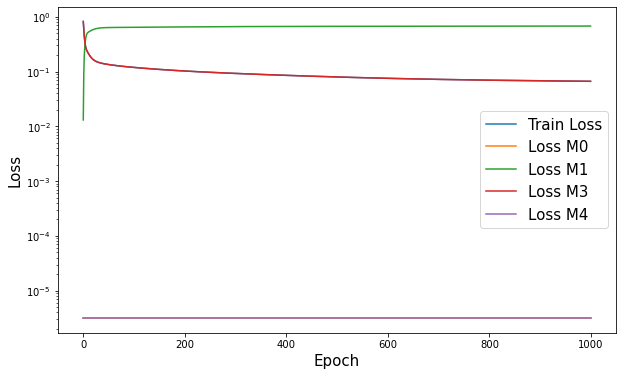

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.007092444
RMSE of after m1 0.007848197
RMSE of after m3 2.0466306
RMSE of after m4 2.007562
RMSE of after m0 0.0072186105
RMSE of after m1 0.057978842
RMSE of after m3 3.2557588
RMSE of after m4 3.5442238
RMSE of after m0 0.010859054
RMSE of after m1 0.032674108
RMSE of after m3 4.795534
RMSE of after m4 5.2876296
RMSE of after m0 0.011451844
RMSE of after m1 0.0146057615
RMSE of after m3 4.630353
RMSE of after m4 5.0451355
RMSE of after m0 0.008204393
RMSE of after m1 0.009301169
RMSE of after m3 4.538585
RMSE of after m4 4.894932
RMSE of after m0 0.0072264583
RMSE of after m1 0.0074025407
RMSE of after m3 4.4740176
RMSE of after m4 4.7971396
RMSE of after m0 0.0072240196
RMSE of after m1 0.007011356
RMSE of after m3 4.442372
RMSE of after m4 4.7936068
RMSE of after m0 0.0071291677
RMSE of after m1 0.0056008175
RMSE of after m3 4.4411964
RMSE of after m4 4.7973948
RMSE of after m0 0.0065425863
RMSE of after m1 0.0063338405
RMSE of after m3 4.4831424
RMSE of after m4

RMSE of after m3 5.348281
RMSE of after m4 4.473183
RMSE of after m0 0.0059244377
RMSE of after m1 0.005766989
RMSE of after m3 5.5904245
RMSE of after m4 4.631492
RMSE of after m0 0.005595526
RMSE of after m1 0.0053713857
RMSE of after m3 5.7426696
RMSE of after m4 4.7546015
RMSE of after m0 0.0047356156
RMSE of after m1 0.0047869524
RMSE of after m3 5.749099
RMSE of after m4 4.687522
RMSE of after m0 0.005299654
RMSE of after m1 0.005758446
RMSE of after m3 5.469589
RMSE of after m4 4.4278708
RMSE of after m0 0.0045973565
RMSE of after m1 0.005000023
RMSE of after m3 5.330297
RMSE of after m4 4.3304796
RMSE of after m0 0.004732537
RMSE of after m1 0.0051947464
RMSE of after m3 5.2930226
RMSE of after m4 4.3252788
RMSE of after m0 0.0043288134
RMSE of after m1 0.0050013917
RMSE of after m3 5.1382685
RMSE of after m4 4.282802
RMSE of after m0 0.0043071164
RMSE of after m1 0.0047019315
RMSE of after m3 4.676382
RMSE of after m4 4.081497
RMSE of after m0 0.0049033463
RMSE of after m1 0.0

RMSE of after m3 4.0401583
RMSE of after m4 4.8978004
RMSE of after m0 0.0052450798
RMSE of after m1 0.0057243626
RMSE of after m3 4.0415907
RMSE of after m4 4.9077926
RMSE of after m0 0.0064581013
RMSE of after m1 0.0067937016
RMSE of after m3 4.0559845
RMSE of after m4 4.9464874
RMSE of after m0 0.0057824305
RMSE of after m1 0.0061472314
RMSE of after m3 3.9086795
RMSE of after m4 4.7734637
RMSE of after m0 0.01008138
RMSE of after m1 0.009535095
RMSE of after m3 3.8307736
RMSE of after m4 4.6579943
RMSE of after m0 0.010750286
RMSE of after m1 0.009886862
RMSE of after m3 4.038451
RMSE of after m4 4.8748236
RMSE of after m0 0.005939309
RMSE of after m1 0.0059880936
RMSE of after m3 4.0555863
RMSE of after m4 4.878644
RMSE of after m0 0.008166913
RMSE of after m1 0.00796683
RMSE of after m3 4.3593073
RMSE of after m4 5.30735
RMSE of after m0 0.0057002343
RMSE of after m1 0.006076552
RMSE of after m3 4.397028
RMSE of after m4 5.420622
RMSE of after m0 0.005233563
RMSE of after m1 0.00

RMSE of after m4 6.0533724
RMSE of after m0 0.0060744965
RMSE of after m1 0.0059199254
RMSE of after m3 4.7771025
RMSE of after m4 5.9856873
RMSE of after m0 0.0066348244
RMSE of after m1 0.006500912
RMSE of after m3 4.7401123
RMSE of after m4 5.9382687
RMSE of after m0 0.006982732
RMSE of after m1 0.0065792943
RMSE of after m3 4.918359
RMSE of after m4 6.1967783
RMSE of after m0 0.0057325433
RMSE of after m1 0.005649519
RMSE of after m3 4.905453
RMSE of after m4 6.1653676
RMSE of after m0 0.0052289045
RMSE of after m1 0.0051796567
RMSE of after m3 4.7666245
RMSE of after m4 5.962575
RMSE of after m0 0.0060613607
RMSE of after m1 0.0057194037
RMSE of after m3 4.6850557
RMSE of after m4 5.848457
RMSE of after m0 0.0057311407
RMSE of after m1 0.005899812
RMSE of after m3 4.6488447
RMSE of after m4 5.816407
RMSE of after m0 0.006712056
RMSE of after m1 0.0071697673
RMSE of after m3 4.4818716
RMSE of after m4 5.582628
RMSE of after m0 0.004170605
RMSE of after m1 0.0045973924
RMSE of after

RMSE of after m1 0.009425311
RMSE of after m3 6.583821
RMSE of after m4 7.4559336
RMSE of after m0 0.00689566
RMSE of after m1 0.042965617
RMSE of after m3 6.6228075
RMSE of after m4 7.4307895
RMSE of after m0 0.006915123
RMSE of after m1 0.010672074
RMSE of after m3 6.897696
RMSE of after m4 7.6116643
RMSE of after m0 0.0068984726
RMSE of after m1 0.010450241
RMSE of after m3 6.8852577
RMSE of after m4 7.6050067
RMSE of after m0 0.006726783
RMSE of after m1 0.009216866
RMSE of after m3 6.9674187
RMSE of after m4 7.7357993
RMSE of after m0 0.0065055364
RMSE of after m1 0.007371722
RMSE of after m3 6.953456
RMSE of after m4 7.697526
RMSE of after m0 0.0059333225
RMSE of after m1 0.006170201
RMSE of after m3 6.8990703
RMSE of after m4 7.593146
RMSE of after m0 0.006148176
RMSE of after m1 0.0053763506
RMSE of after m3 6.8666844
RMSE of after m4 7.5310497
RMSE of after m0 0.006256581
RMSE of after m1 0.0077049513
RMSE of after m3 6.7168694
RMSE of after m4 7.3445554
RMSE of after m0 0.006

RMSE of after m1 0.0067410897
RMSE of after m3 2.1541405
RMSE of after m4 2.1368663
RMSE of after m0 0.008717348
RMSE of after m1 0.0061570625
RMSE of after m3 2.0812852
RMSE of after m4 2.0625992
RMSE of after m0 0.010024031
RMSE of after m1 0.0067808973
RMSE of after m3 2.0423622
RMSE of after m4 2.0330884
RMSE of after m0 0.009456333
RMSE of after m1 0.0060827206
RMSE of after m3 1.918305
RMSE of after m4 1.888438
RMSE of after m0 0.007985545
RMSE of after m1 0.005669772
RMSE of after m3 1.9032532
RMSE of after m4 1.8727877
RMSE of after m0 0.009833404
RMSE of after m1 0.0065205903
RMSE of after m3 1.8036845
RMSE of after m4 1.7635108
RMSE of after m0 0.008894916
RMSE of after m1 0.0070202514
RMSE of after m3 1.8981616
RMSE of after m4 1.8664076
RMSE of after m0 0.007635144
RMSE of after m1 0.006708077
RMSE of after m3 1.6640733
RMSE of after m4 1.6192678
RMSE of after m0 0.0072391164
RMSE of after m1 0.006672255
RMSE of after m3 1.7539281
RMSE of after m4 1.7230527
RMSE of after m0

RMSE of after m1 0.0075589214
RMSE of after m3 1.474627
RMSE of after m4 1.3969842
RMSE of after m0 0.009042391
RMSE of after m1 0.008914097
RMSE of after m3 1.4696332
RMSE of after m4 1.3918338
RMSE of after m0 0.010050349
RMSE of after m1 0.008090088
RMSE of after m3 1.6704652
RMSE of after m4 1.5816311
RMSE of after m0 0.013300651
RMSE of after m1 0.009561247
RMSE of after m3 1.7593081
RMSE of after m4 1.6670918
RMSE of after m0 0.016242495
RMSE of after m1 0.009421648
RMSE of after m3 1.8256639
RMSE of after m4 1.7281648
RMSE of after m0 0.013754997
RMSE of after m1 0.009305861
RMSE of after m3 1.9348776
RMSE of after m4 1.8270115
RMSE of after m0 0.012873815
RMSE of after m1 0.0076690596
RMSE of after m3 1.9638803
RMSE of after m4 1.8506292
RMSE of after m0 0.010669863
RMSE of after m1 0.008590032
RMSE of after m3 1.9592161
RMSE of after m4 1.8438572
RMSE of after m0 0.010301056
RMSE of after m1 0.008942747
RMSE of after m3 1.9359103
RMSE of after m4 1.8222944
RMSE of after m0 0.0

RMSE of after m1 0.0043317173
RMSE of after m3 3.4801664
RMSE of after m4 3.9571
RMSE of after m0 0.005515422
RMSE of after m1 0.0055323737
RMSE of after m3 3.413163
RMSE of after m4 3.904676
RMSE of after m0 0.0065055685
RMSE of after m1 0.006601399
RMSE of after m3 3.3899093
RMSE of after m4 3.8959484
RMSE of after m0 0.008926558
RMSE of after m1 0.009336277
RMSE of after m3 3.3165433
RMSE of after m4 3.8256807
RMSE of after m0 0.0069539244
RMSE of after m1 0.0072456216
RMSE of after m3 3.2058446
RMSE of after m4 3.703324
RMSE of after m0 0.0045443266
RMSE of after m1 0.004969166
RMSE of after m3 3.0017843
RMSE of after m4 3.4578218
RMSE of after m0 0.0050156727
RMSE of after m1 0.0053205127
RMSE of after m3 2.9646635
RMSE of after m4 3.4197206
RMSE of after m0 0.006336733
RMSE of after m1 0.006347134
RMSE of after m3 2.9357522
RMSE of after m4 3.382715
RMSE of after m0 0.008960247
RMSE of after m1 0.008288654
RMSE of after m3 3.1122947
RMSE of after m4 3.5702114
RMSE of after m0 0.0

RMSE of after m1 0.005926739
RMSE of after m3 5.1920056
RMSE of after m4 6.619742
RMSE of after m0 0.0045361943
RMSE of after m1 0.0046862154
RMSE of after m3 5.0982537
RMSE of after m4 6.472284
RMSE of after m0 0.005797921
RMSE of after m1 0.0061562466
RMSE of after m3 5.0844812
RMSE of after m4 6.4843807
RMSE of after m0 0.0062356414
RMSE of after m1 0.0064254696
RMSE of after m3 4.976068
RMSE of after m4 6.3730745
RMSE of after m0 0.0051736864
RMSE of after m1 0.005190148
RMSE of after m3 4.8889194
RMSE of after m4 6.2235055
RMSE of after m0 0.008215388
RMSE of after m1 0.00789897
RMSE of after m3 4.88712
RMSE of after m4 6.170915
RMSE of after m0 0.004932664
RMSE of after m1 0.005116673
RMSE of after m3 4.844018
RMSE of after m4 6.097771
RMSE of after m0 0.007944606
RMSE of after m1 0.0073499694
RMSE of after m3 4.8999515
RMSE of after m4 6.189247
RMSE of after m0 0.0048231645
RMSE of after m1 0.0050131464
RMSE of after m3 4.8533106
RMSE of after m4 6.1027904
RMSE of after m0 0.004

RMSE of after m0 0.0039037657
RMSE of after m1 0.0048383884
RMSE of after m3 5.003214
RMSE of after m4 5.7247677
RMSE of after m0 0.008288286
RMSE of after m1 0.009203911
RMSE of after m3 5.2009907
RMSE of after m4 5.9807534
RMSE of after m0 0.0054399935
RMSE of after m1 0.0060386616
RMSE of after m3 5.3813443
RMSE of after m4 6.204752
RMSE of after m0 0.0058711157
RMSE of after m1 0.006234166
RMSE of after m3 5.6699247
RMSE of after m4 6.5648174
RMSE of after m0 0.004689895
RMSE of after m1 0.0046912045
RMSE of after m3 5.787671
RMSE of after m4 6.690873
RMSE of after m0 0.006183745
RMSE of after m1 0.0059563387
RMSE of after m3 6.08023
RMSE of after m4 6.9884367
RMSE of after m0 0.005759447
RMSE of after m1 0.00639482
RMSE of after m3 6.7220263
RMSE of after m4 7.736527
RMSE of after m0 0.00585085
RMSE of after m1 0.008171329
RMSE of after m3 6.853249
RMSE of after m4 7.907995
RMSE of after m0 0.005700727
RMSE of after m1 0.005511542
RMSE of after m3 6.850216
RMSE of after m4 7.88961

RMSE of after m3 1.9238347
RMSE of after m4 1.8162115
RMSE of after m0 0.00451509
RMSE of after m1 0.00829154
RMSE of after m3 2.005471
RMSE of after m4 1.8968505
RMSE of after m0 0.0047562313
RMSE of after m1 0.00842476
RMSE of after m3 1.8409896
RMSE of after m4 1.7348484
RMSE of after m0 0.0043082247
RMSE of after m1 0.008916696
RMSE of after m3 1.8465726
RMSE of after m4 1.7441814
RMSE of after m0 0.007754657
RMSE of after m1 0.009096421
RMSE of after m3 1.7201883
RMSE of after m4 1.6183214
RMSE of after m0 0.014439835
RMSE of after m1 0.010165618
RMSE of after m3 1.8823886
RMSE of after m4 1.7730836
RMSE of after m0 0.009698144
RMSE of after m1 0.009357091
RMSE of after m3 1.9013375
RMSE of after m4 1.7912346
RMSE of after m0 0.012847791
RMSE of after m1 0.009250146
RMSE of after m3 1.7072501
RMSE of after m4 1.6441026
RMSE of after m0 0.014036913
RMSE of after m1 0.007052712
RMSE of after m3 1.4493722
RMSE of after m4 1.4329768
RMSE of after m0 0.01631992
RMSE of after m1 0.00789

RMSE of after m0 0.018546607
RMSE of after m1 0.0091418205
RMSE of after m3 1.348364
RMSE of after m4 1.2759255
RMSE of after m0 0.013522024
RMSE of after m1 0.008691033
RMSE of after m3 1.3409094
RMSE of after m4 1.267744
RMSE of after m0 0.0089135915
RMSE of after m1 0.007513144
RMSE of after m3 1.31706
RMSE of after m4 1.2461
RMSE of after m0 0.011221048
RMSE of after m1 0.00854877
RMSE of after m3 1.3755692
RMSE of after m4 1.302649
RMSE of after m0 0.012202116
RMSE of after m1 0.008664892
RMSE of after m3 1.3838753
RMSE of after m4 1.3098713
RMSE of after m0 0.0079681855
RMSE of after m1 0.008316539
RMSE of after m3 1.485805
RMSE of after m4 1.4040118
RMSE of after m0 0.007961395
RMSE of after m1 0.007931324
RMSE of after m3 1.5276908
RMSE of after m4 1.4401618
RMSE of after m0 0.008984956
RMSE of after m1 0.0087163
RMSE of after m3 1.4733142
RMSE of after m4 1.3900343
RMSE of after m0 0.010092811
RMSE of after m1 0.007891953
RMSE of after m3 1.6057013
RMSE of after m4 1.5131809
R

RMSE of after m0 0.009174769
RMSE of after m1 0.00954418
RMSE of after m3 2.6034505
RMSE of after m4 2.8739586
RMSE of after m0 0.0075862436
RMSE of after m1 0.007322312
RMSE of after m3 2.5793855
RMSE of after m4 2.8630028
RMSE of after m0 0.012492287
RMSE of after m1 0.011438019
RMSE of after m3 2.544378
RMSE of after m4 2.8865366
RMSE of after m0 0.009865902
RMSE of after m1 0.009639318
RMSE of after m3 2.901117
RMSE of after m4 3.2386403
RMSE of after m0 0.0056978525
RMSE of after m1 0.0054474096
RMSE of after m3 3.3581579
RMSE of after m4 3.804788
RMSE of after m0 0.00676296
RMSE of after m1 0.006373678
RMSE of after m3 3.4848824
RMSE of after m4 3.970888
RMSE of after m0 0.006896395
RMSE of after m1 0.00623442
RMSE of after m3 3.613435
RMSE of after m4 4.1372337
RMSE of after m0 0.0058523584
RMSE of after m1 0.0055043045
RMSE of after m3 3.6578324
RMSE of after m4 4.1778426
RMSE of after m0 0.0075908187
RMSE of after m1 0.0074520903
RMSE of after m3 3.6472726
RMSE of after m4 4.1

RMSE of after m1 0.0042997776
RMSE of after m3 5.444623
RMSE of after m4 7.1215634
RMSE of after m0 0.0048783366
RMSE of after m1 0.004866665
RMSE of after m3 5.3926015
RMSE of after m4 7.0497136
RMSE of after m0 0.0051350608
RMSE of after m1 0.005195898
RMSE of after m3 5.3716555
RMSE of after m4 7.0593586
RMSE of after m0 0.0065221633
RMSE of after m1 0.006393554
RMSE of after m3 5.3713827
RMSE of after m4 7.1370063
RMSE of after m0 0.007896757
RMSE of after m1 0.0076575708
RMSE of after m3 5.3258657
RMSE of after m4 7.1280656
RMSE of after m0 0.009564729
RMSE of after m1 0.009014177
RMSE of after m3 5.2155986
RMSE of after m4 6.8820252
RMSE of after m0 0.0075582573
RMSE of after m1 0.007229273
RMSE of after m3 5.133634
RMSE of after m4 6.638625
RMSE of after m0 0.0072621503
RMSE of after m1 0.0068505066
RMSE of after m3 5.195792
RMSE of after m4 6.7340255
RMSE of after m0 0.0061349403
RMSE of after m1 0.0061621945
RMSE of after m3 5.430352
RMSE of after m4 7.1638227
RMSE of after m0

RMSE of after m3 5.7946906
RMSE of after m4 7.2596607
RMSE of after m0 0.0054424326
RMSE of after m1 0.0059920414
RMSE of after m3 5.8041925
RMSE of after m4 7.2578025
RMSE of after m0 0.0045522866
RMSE of after m1 0.004734096
RMSE of after m3 5.74167
RMSE of after m4 7.169062
RMSE of after m0 0.0046042698
RMSE of after m1 0.0048923395
RMSE of after m3 5.685203
RMSE of after m4 7.105557
RMSE of after m0 0.004063011
RMSE of after m1 0.0042235167
RMSE of after m3 5.6032577
RMSE of after m4 6.9574347
RMSE of after m0 0.0043328954
RMSE of after m1 0.0044821855
RMSE of after m3 5.584169
RMSE of after m4 6.8903513
RMSE of after m0 0.003922718
RMSE of after m1 0.0042694556
RMSE of after m3 5.4985685
RMSE of after m4 6.782301
RMSE of after m0 0.0041916203
RMSE of after m1 0.0045377337
RMSE of after m3 5.3883376
RMSE of after m4 6.6509585
RMSE of after m0 0.0044855596
RMSE of after m1 0.0046722945
RMSE of after m3 5.302447
RMSE of after m4 6.5551634
RMSE of after m0 0.006255513
RMSE of after m1

RMSE of after m1 0.006092217
RMSE of after m3 5.5165668
RMSE of after m4 5.5271006
RMSE of after m0 0.0058874306
RMSE of after m1 0.006254398
RMSE of after m3 5.5971537
RMSE of after m4 5.6246495
RMSE of after m0 0.004857154
RMSE of after m1 0.006082345
RMSE of after m3 5.5523763
RMSE of after m4 5.6151385
RMSE of after m0 0.004638849
RMSE of after m1 0.005641585
RMSE of after m3 5.485927
RMSE of after m4 5.5135736
RMSE of after m0 0.009064009
RMSE of after m1 0.0060647232
RMSE of after m3 5.515938
RMSE of after m4 5.5322204
RMSE of after m0 0.009241361
RMSE of after m1 0.0072570746
RMSE of after m3 5.648378
RMSE of after m4 5.651788
RMSE of after m0 0.0058590826
RMSE of after m1 0.006304481
RMSE of after m3 5.762699
RMSE of after m4 5.7645426
RMSE of after m0 0.0063289334
RMSE of after m1 0.0070982235
RMSE of after m3 5.785264
RMSE of after m4 5.802155
RMSE of after m0 0.006035286
RMSE of after m1 0.0067983055
RMSE of after m3 5.8030386
RMSE of after m4 5.8584294
RMSE of after m0 0.00

RMSE of after m1 0.0067450767
RMSE of after m3 0.856106
RMSE of after m4 0.7808437
RMSE of after m0 0.017421013
RMSE of after m1 0.007627
RMSE of after m3 0.9437169
RMSE of after m4 0.8604252
RMSE of after m0 0.017770551
RMSE of after m1 0.00842204
RMSE of after m3 0.9291491
RMSE of after m4 0.8430792
RMSE of after m0 0.010936928
RMSE of after m1 0.007784904
RMSE of after m3 0.90179604
RMSE of after m4 0.8202192
RMSE of after m0 0.009904488
RMSE of after m1 0.007217494
RMSE of after m3 0.9024547
RMSE of after m4 0.8207883
RMSE of after m0 0.007929592
RMSE of after m1 0.0070782765
RMSE of after m3 0.9088395
RMSE of after m4 0.8246133
RMSE of after m0 0.009698702
RMSE of after m1 0.0073610367
RMSE of after m3 0.9267093
RMSE of after m4 0.83801746
RMSE of after m0 0.010181545
RMSE of after m1 0.007035858
RMSE of after m3 0.93375754
RMSE of after m4 0.84703
RMSE of after m0 0.009249682
RMSE of after m1 0.0075528314
RMSE of after m3 0.9221397
RMSE of after m4 0.8322889
RMSE of after m0 0.01

RMSE of after m1 0.012420821
RMSE of after m3 2.1185944
RMSE of after m4 2.0475032
RMSE of after m0 0.006136228
RMSE of after m1 0.011279796
RMSE of after m3 2.4406366
RMSE of after m4 2.3693156
RMSE of after m0 0.006238031
RMSE of after m1 0.012073296
RMSE of after m3 2.2965214
RMSE of after m4 2.227846
RMSE of after m0 0.0066094575
RMSE of after m1 0.00963252
RMSE of after m3 2.3651037
RMSE of after m4 2.2956483
RMSE of after m0 0.0074953716
RMSE of after m1 0.009245736
RMSE of after m3 2.602919
RMSE of after m4 2.530453
RMSE of after m0 0.006479989
RMSE of after m1 0.010287483
RMSE of after m3 2.7320933
RMSE of after m4 2.6644678
RMSE of after m0 0.0062736133
RMSE of after m1 0.013895924
RMSE of after m3 2.8595693
RMSE of after m4 2.7958136
RMSE of after m0 0.018063584
RMSE of after m1 0.016366506
RMSE of after m3 3.2289681
RMSE of after m4 3.1706972
RMSE of after m0 0.013680857
RMSE of after m1 0.017151587
RMSE of after m3 3.906304
RMSE of after m4 4.0097504
RMSE of after m0 0.0061

RMSE of after m1 0.0049528265
RMSE of after m3 4.1565876
RMSE of after m4 5.016151
RMSE of after m0 0.011182594
RMSE of after m1 0.011552343
RMSE of after m3 4.246203
RMSE of after m4 5.1614046
RMSE of after m0 0.009990212
RMSE of after m1 0.009538116
RMSE of after m3 4.15604
RMSE of after m4 5.0350533
RMSE of after m0 0.0065827966
RMSE of after m1 0.0063536535
RMSE of after m3 4.2085505
RMSE of after m4 5.055911
RMSE of after m0 0.004161438
RMSE of after m1 0.0047125313
RMSE of after m3 4.2073703
RMSE of after m4 5.0561
RMSE of after m0 0.00435588
RMSE of after m1 0.005040347
RMSE of after m3 4.1493793
RMSE of after m4 4.9904456
RMSE of after m0 0.004610594
RMSE of after m1 0.005016569
RMSE of after m3 4.244338
RMSE of after m4 5.1349115
RMSE of after m0 0.005407623
RMSE of after m1 0.005752004
RMSE of after m3 4.256339
RMSE of after m4 5.121612
RMSE of after m0 0.0068773245
RMSE of after m1 0.00674081
RMSE of after m3 4.290444
RMSE of after m4 5.1575246
RMSE of after m0 0.0040622996


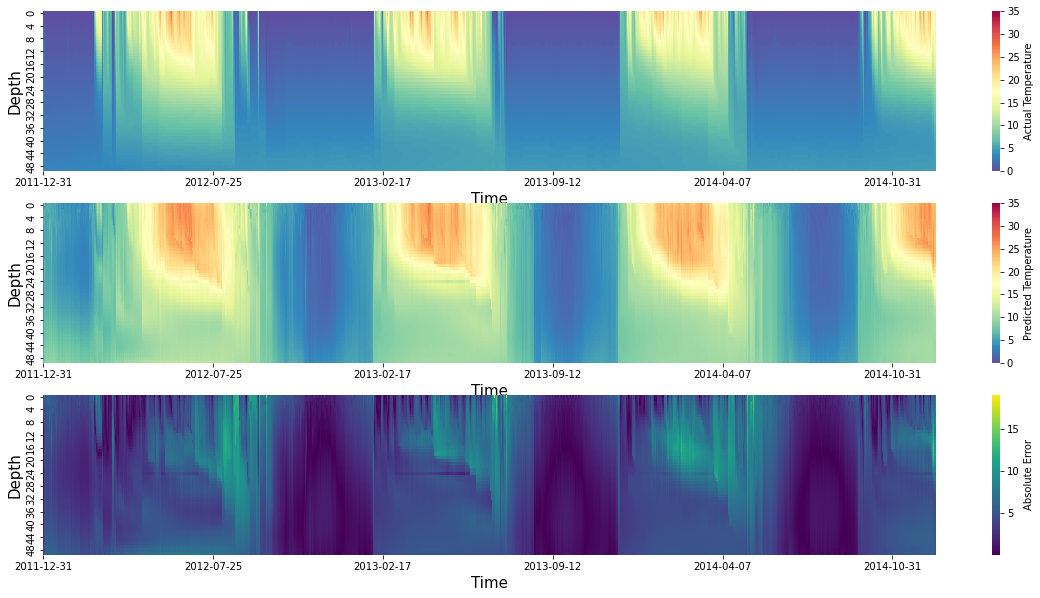

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

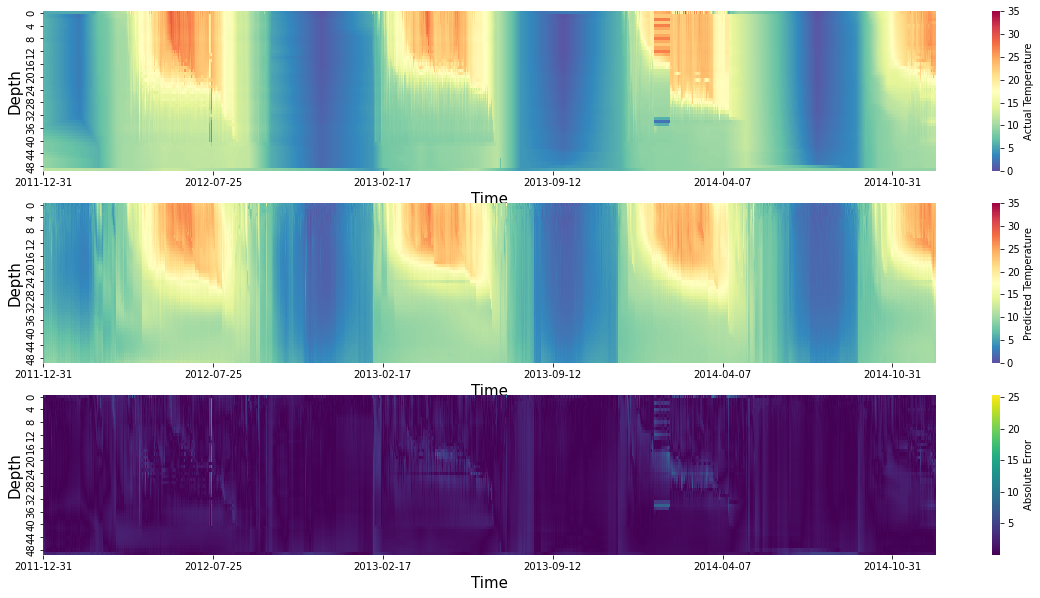

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.004135971
RMSE of after m1 0.004479291
RMSE of after m3 5.2940235
RMSE of after m4 6.887894
RMSE of after m0 0.0061636027
RMSE of after m1 0.006421405
RMSE of after m3 5.3470955
RMSE of after m4 6.965194
RMSE of after m0 0.0062802625
RMSE of after m1 0.006737346
RMSE of after m3 5.1388927
RMSE of after m4 6.649361
RMSE of after m0 0.0054500657
RMSE of after m1 0.005826562
RMSE of after m3 5.055238
RMSE of after m4 6.5341234
RMSE of after m0 0.0046294285
RMSE of after m1 0.0050573465
RMSE of after m3 5.011471
RMSE of after m4 6.488319
RMSE of after m0 0.005027943
RMSE of after m1 0.005173076
RMSE of after m3 5.020232
RMSE of after m4 6.5329313
RMSE of after m0 0.00583606
RMSE of after m1 0.0057957144
RMSE of after m3 5.05812
RMSE of after m4 6.5516458
RMSE of after m0 0.006651819
RMSE of after m1 0.006739272
RMSE of after m3 5.053119
RMSE of after m4 6.479707
RMSE of after m0 0.0053638075
RMSE of after m1 0.0055737193
RMSE of after m3 5.098931
RMSE of after m4 6.55963

RMSE of after m3 5.739104
RMSE of after m4 6.56176
RMSE of after m0 0.005710668
RMSE of after m1 0.006592579
RMSE of after m3 5.836111
RMSE of after m4 6.6412997
RMSE of after m0 0.0074287755
RMSE of after m1 0.007723892
RMSE of after m3 5.627494
RMSE of after m4 6.39242
RMSE of after m0 0.007425567
RMSE of after m1 0.008198519
RMSE of after m3 5.4315906
RMSE of after m4 6.162804
RMSE of after m0 0.0071091536
RMSE of after m1 0.007957893
RMSE of after m3 5.527887
RMSE of after m4 6.2359943
RMSE of after m0 0.0059612324
RMSE of after m1 0.0064049154
RMSE of after m3 5.629238
RMSE of after m4 6.343455
RMSE of after m0 0.004787584
RMSE of after m1 0.005008916
RMSE of after m3 5.6504107
RMSE of after m4 6.3472953
RMSE of after m0 0.00460369
RMSE of after m1 0.0050127776
RMSE of after m3 5.395137
RMSE of after m4 6.036847
RMSE of after m0 0.0084613515
RMSE of after m1 0.008637038
RMSE of after m3 5.5401173
RMSE of after m4 6.174981
RMSE of after m0 0.0049473788
RMSE of after m1 0.004923037


RMSE of after m1 0.008516342
RMSE of after m3 3.0524333
RMSE of after m4 3.1523492
RMSE of after m0 0.009739668
RMSE of after m1 0.008662264
RMSE of after m3 3.0858464
RMSE of after m4 3.187634
RMSE of after m0 0.016326483
RMSE of after m1 0.01222885
RMSE of after m3 3.1032746
RMSE of after m4 3.2109897
RMSE of after m0 0.020587701
RMSE of after m1 0.014441794
RMSE of after m3 3.106135
RMSE of after m4 3.195059
RMSE of after m0 0.013515552
RMSE of after m1 0.010522913
RMSE of after m3 2.9866092
RMSE of after m4 3.0505264
RMSE of after m0 0.021970795
RMSE of after m1 0.013257816
RMSE of after m3 2.9815156
RMSE of after m4 3.0550587
RMSE of after m0 0.01615543
RMSE of after m1 0.009968293
RMSE of after m3 2.9089441
RMSE of after m4 2.9722598
RMSE of after m0 0.011371418
RMSE of after m1 0.008400792
RMSE of after m3 2.8528612
RMSE of after m4 2.8996198
RMSE of after m0 0.0094508575
RMSE of after m1 0.006913673
RMSE of after m3 2.823279
RMSE of after m4 2.8602548
RMSE of after m0 0.0102586

RMSE of after m1 0.013560781
RMSE of after m3 3.759592
RMSE of after m4 3.953433
RMSE of after m0 0.009007552
RMSE of after m1 0.01140087
RMSE of after m3 3.8006935
RMSE of after m4 4.0014753
RMSE of after m0 0.009999305
RMSE of after m1 0.01701482
RMSE of after m3 4.112827
RMSE of after m4 4.453323
RMSE of after m0 0.0075813895
RMSE of after m1 0.011347573
RMSE of after m3 4.015987
RMSE of after m4 4.4168024
RMSE of after m0 0.0069905347
RMSE of after m1 0.007039116
RMSE of after m3 3.6176915
RMSE of after m4 3.9261012
RMSE of after m0 0.008604475
RMSE of after m1 0.009078784
RMSE of after m3 2.6660464
RMSE of after m4 2.8375163
RMSE of after m0 0.0051978994
RMSE of after m1 0.0043201423
RMSE of after m3 2.5991542
RMSE of after m4 2.7718072
RMSE of after m0 0.005951422
RMSE of after m1 0.006161869
RMSE of after m3 2.7986386
RMSE of after m4 2.980389
RMSE of after m0 0.006906137
RMSE of after m1 0.01564284
RMSE of after m3 4.729286
RMSE of after m4 5.3266625
RMSE of after m0 0.01037758

RMSE of after m3 4.3596225
RMSE of after m4 5.0894237
RMSE of after m0 0.0046010017
RMSE of after m1 0.0043991785
RMSE of after m3 4.324434
RMSE of after m4 5.0463
RMSE of after m0 0.006490891
RMSE of after m1 0.006805569
RMSE of after m3 4.4288425
RMSE of after m4 5.2307534
RMSE of after m0 0.017036203
RMSE of after m1 0.01731352
RMSE of after m3 4.3016396
RMSE of after m4 5.121265
RMSE of after m0 0.0067862114
RMSE of after m1 0.007154914
RMSE of after m3 4.102696
RMSE of after m4 4.861814
RMSE of after m0 0.009118915
RMSE of after m1 0.008752974
RMSE of after m3 4.136557
RMSE of after m4 4.905832
RMSE of after m0 0.008797841
RMSE of after m1 0.008288839
RMSE of after m3 4.220887
RMSE of after m4 4.980421
RMSE of after m0 0.0054461365
RMSE of after m1 0.005819103
RMSE of after m3 4.1986885
RMSE of after m4 4.9602833
RMSE of after m0 0.007940822
RMSE of after m1 0.008174031
RMSE of after m3 4.199724
RMSE of after m4 4.9997287
RMSE of after m0 0.00633558
RMSE of after m1 0.006577259
RM

RMSE of after m4 5.2532797
RMSE of after m0 0.0052478784
RMSE of after m1 0.006010641
RMSE of after m3 4.457692
RMSE of after m4 5.2638183
RMSE of after m0 0.004783649
RMSE of after m1 0.0055113966
RMSE of after m3 4.3714685
RMSE of after m4 5.1418176
RMSE of after m0 0.0048920214
RMSE of after m1 0.0057224925
RMSE of after m3 4.3219395
RMSE of after m4 5.0762954
RMSE of after m0 0.004935181
RMSE of after m1 0.0056235
RMSE of after m3 4.307486
RMSE of after m4 5.0554433
RMSE of after m0 0.008491238
RMSE of after m1 0.009000938
RMSE of after m3 4.323518
RMSE of after m4 5.075532
RMSE of after m0 0.011234219
RMSE of after m1 0.01098658
RMSE of after m3 4.691596
RMSE of after m4 5.541187
RMSE of after m0 0.007683728
RMSE of after m1 0.007288114
RMSE of after m3 4.8315306
RMSE of after m4 5.7360077
RMSE of after m0 0.005236175
RMSE of after m1 0.0051956642
RMSE of after m3 4.855673
RMSE of after m4 5.7844644
RMSE of after m0 0.0076098396
RMSE of after m1 0.007823445
RMSE of after m3 4.8511

RMSE of after m0 0.006140727
RMSE of after m1 0.006710685
RMSE of after m3 5.1661177
RMSE of after m4 5.758051
RMSE of after m0 0.0056409263
RMSE of after m1 0.0061174226
RMSE of after m3 5.088954
RMSE of after m4 5.646793
RMSE of after m0 0.003934341
RMSE of after m1 0.004460302
RMSE of after m3 5.329809
RMSE of after m4 5.966999
RMSE of after m0 0.004275898
RMSE of after m1 0.004617512
RMSE of after m3 5.278995
RMSE of after m4 5.8834767
RMSE of after m0 0.0043050605
RMSE of after m1 0.0044840495
RMSE of after m3 5.212651
RMSE of after m4 5.7887597
RMSE of after m0 0.0123187145
RMSE of after m1 0.012166229
RMSE of after m3 5.007333
RMSE of after m4 5.5944824
RMSE of after m0 0.00512104
RMSE of after m1 0.0051441216
RMSE of after m3 4.430749
RMSE of after m4 4.8694186
RMSE of after m0 0.0052342145
RMSE of after m1 0.0062986137
RMSE of after m3 4.442833
RMSE of after m4 4.864048
RMSE of after m0 0.007656165
RMSE of after m1 0.009266086
RMSE of after m3 4.530203
RMSE of after m4 4.92977

RMSE of after m3 2.7409444
RMSE of after m4 2.8106418
RMSE of after m0 0.017034769
RMSE of after m1 0.009922949
RMSE of after m3 2.708844
RMSE of after m4 2.7702672
RMSE of after m0 0.014325649
RMSE of after m1 0.008761942
RMSE of after m3 2.6778076
RMSE of after m4 2.7480395
RMSE of after m0 0.013605407
RMSE of after m1 0.008207152
RMSE of after m3 2.5984035
RMSE of after m4 2.6552222
RMSE of after m0 0.01465181
RMSE of after m1 0.008687934
RMSE of after m3 2.5472472
RMSE of after m4 2.5878575
RMSE of after m0 0.011339138
RMSE of after m1 0.0075343936
RMSE of after m3 2.4746068
RMSE of after m4 2.5018625
RMSE of after m0 0.00649333
RMSE of after m1 0.005321444
RMSE of after m3 2.4008245
RMSE of after m4 2.4180574
RMSE of after m0 0.006080522
RMSE of after m1 0.005899815
RMSE of after m3 2.2144024
RMSE of after m4 2.2252343
RMSE of after m0 0.006016001
RMSE of after m1 0.0055643166
RMSE of after m3 2.2584367
RMSE of after m4 2.2831528
RMSE of after m0 0.009213317
RMSE of after m1 0.006

RMSE of after m1 0.012634855
RMSE of after m3 2.4712503
RMSE of after m4 2.373453
RMSE of after m0 0.010990784
RMSE of after m1 0.015020227
RMSE of after m3 2.3103142
RMSE of after m4 2.2031403
RMSE of after m0 0.009954168
RMSE of after m1 0.009127014
RMSE of after m3 2.4168267
RMSE of after m4 2.2969353
RMSE of after m0 0.012887677
RMSE of after m1 0.009344835
RMSE of after m3 2.4836104
RMSE of after m4 2.36458
RMSE of after m0 0.012880791
RMSE of after m1 0.009034629
RMSE of after m3 2.7278204
RMSE of after m4 2.6052108
RMSE of after m0 0.009250573
RMSE of after m1 0.009625748
RMSE of after m3 3.3757079
RMSE of after m4 3.5226803
RMSE of after m0 0.007156597
RMSE of after m1 0.0066327355
RMSE of after m3 3.2723937
RMSE of after m4 3.5133138
RMSE of after m0 0.0068599945
RMSE of after m1 0.0058419867
RMSE of after m3 3.2252588
RMSE of after m4 3.4704864
RMSE of after m0 0.0064967107
RMSE of after m1 0.0070181363
RMSE of after m3 3.2664382
RMSE of after m4 3.5262327
RMSE of after m0 0.

RMSE of after m0 0.0077799526
RMSE of after m1 0.0073828083
RMSE of after m3 3.7462761
RMSE of after m4 4.4289126
RMSE of after m0 0.005367802
RMSE of after m1 0.005433345
RMSE of after m3 3.7892883
RMSE of after m4 4.481474
RMSE of after m0 0.007240891
RMSE of after m1 0.006778743
RMSE of after m3 3.82942
RMSE of after m4 4.530129
RMSE of after m0 0.0044183093
RMSE of after m1 0.0050100395
RMSE of after m3 3.810812
RMSE of after m4 4.5300574
RMSE of after m0 0.0040633255
RMSE of after m1 0.004865059
RMSE of after m3 3.7790973
RMSE of after m4 4.509555
RMSE of after m0 0.0071219513
RMSE of after m1 0.007419886
RMSE of after m3 3.6983318
RMSE of after m4 4.4744935
RMSE of after m0 0.009381681
RMSE of after m1 0.010028044
RMSE of after m3 3.4235442
RMSE of after m4 4.1066823
RMSE of after m0 0.0049956357
RMSE of after m1 0.0060590277
RMSE of after m3 3.2806377
RMSE of after m4 3.9258304
RMSE of after m0 0.0049854764
RMSE of after m1 0.006289781
RMSE of after m3 3.2420847
RMSE of after m4

RMSE of after m0 0.0057317056
RMSE of after m1 0.0061757714
RMSE of after m3 4.682471
RMSE of after m4 5.9229736
RMSE of after m0 0.0062087663
RMSE of after m1 0.0068603605
RMSE of after m3 4.6877527
RMSE of after m4 5.982881
RMSE of after m0 0.005559204
RMSE of after m1 0.0059671034
RMSE of after m3 4.756789
RMSE of after m4 6.1355944
RMSE of after m0 0.0052353493
RMSE of after m1 0.0055375826
RMSE of after m3 4.6960993
RMSE of after m4 5.9859495
RMSE of after m0 0.005071928
RMSE of after m1 0.005509111
RMSE of after m3 4.6399946
RMSE of after m4 5.85658
RMSE of after m0 0.0062476676
RMSE of after m1 0.006622574
RMSE of after m3 4.6942034
RMSE of after m4 5.9221416
RMSE of after m0 0.004891336
RMSE of after m1 0.0058876495
RMSE of after m3 4.535622
RMSE of after m4 5.696538
RMSE of after m0 0.0050995597
RMSE of after m1 0.006125914
RMSE of after m3 4.4919815
RMSE of after m4 5.668519
RMSE of after m0 0.010633962
RMSE of after m1 0.01035438
RMSE of after m3 4.678777
RMSE of after m4 5.

RMSE of after m1 0.006984189
RMSE of after m3 5.7712717
RMSE of after m4 6.5711713
RMSE of after m0 0.0046987874
RMSE of after m1 0.004356968
RMSE of after m3 5.8371034
RMSE of after m4 6.5905013
RMSE of after m0 0.004848881
RMSE of after m1 0.004992157
RMSE of after m3 5.9550123
RMSE of after m4 6.7323813
RMSE of after m0 0.0054569333
RMSE of after m1 0.0048673814
RMSE of after m3 6.4395003
RMSE of after m4 7.2675734
RMSE of after m0 0.0054409583
RMSE of after m1 0.0038759452
RMSE of after m3 6.9067345
RMSE of after m4 7.88929
RMSE of after m0 0.0064576357
RMSE of after m1 0.007863801
RMSE of after m3 7.289426
RMSE of after m4 8.429852
RMSE of after m0 0.0060042595
RMSE of after m1 0.0053335875
RMSE of after m3 7.269011
RMSE of after m4 8.3634615
RMSE of after m0 0.005704396
RMSE of after m1 0.04345204
RMSE of after m3 7.530898
RMSE of after m4 8.589106
RMSE of after m0 0.006205593
RMSE of after m1 0.0071130563
RMSE of after m3 7.1088247
RMSE of after m4 7.8272333
RMSE of after m0 0.0

Test RMSE Simulated: 4.910124778747559
Test RMSE Observed Temp: 2.1278209686279297
test L2 Error: 0.40499645471572876
The RMSEs after each modelling stage: [0.00720138 0.01022286 0.         3.97236965 4.52025739]


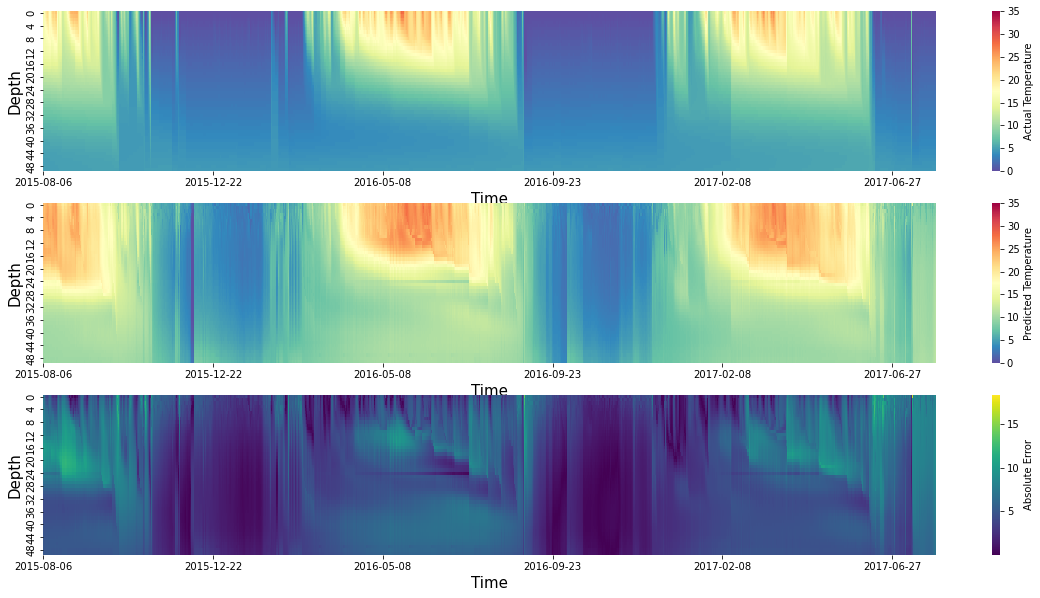

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

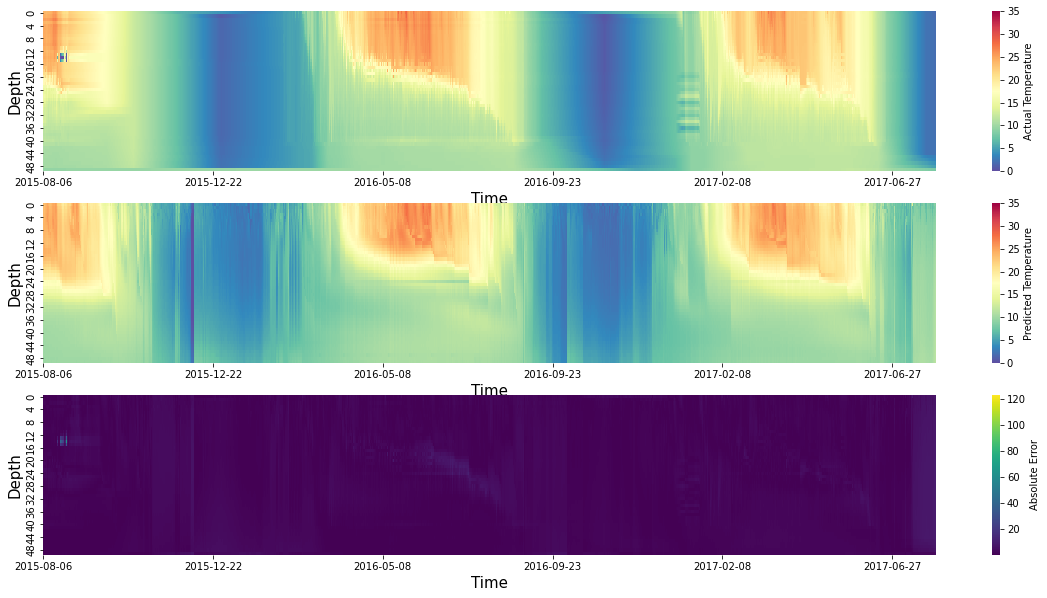

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.095278571831664, Train L2 Error: 0.5392851210388746
Test RMSE: 4.256782652078878, Train L2 Error: 0.5351395661348908


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.015208577187583667, Train L2 Error: 0.002002855682291244
Test RMSE: 0.016331945453217925, Train L2 Error: 0.0020532857040026606


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0073198410576106885, Train L2 Error: 0.0009632675657546159
Test RMSE: 0.019266575643400362, Train L2 Error: 0.002420395383395851


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9136084318161011
L2 Norm: 6.461417198181152


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [53]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

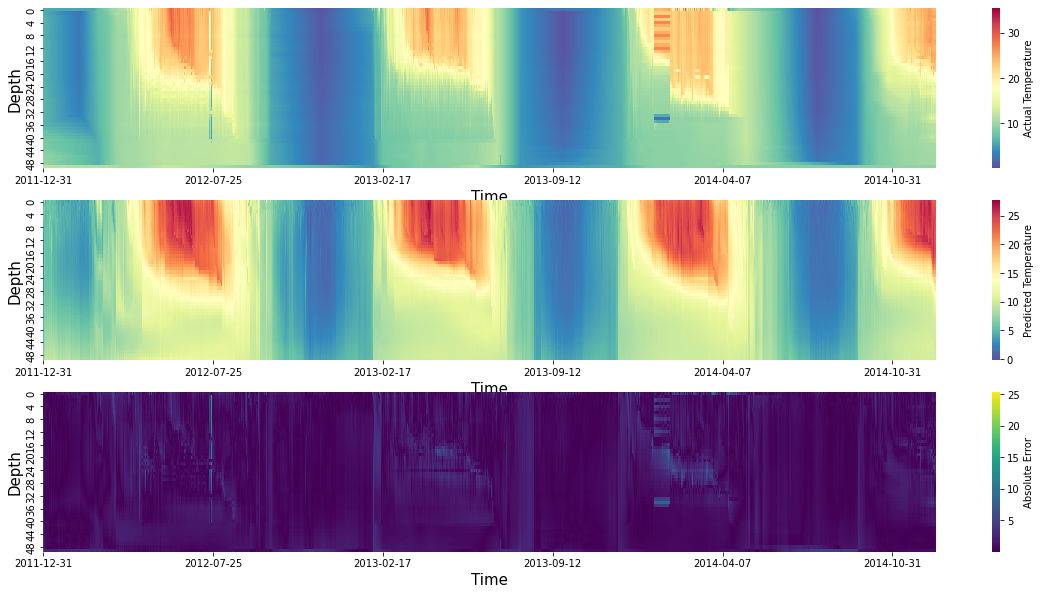

In [54]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

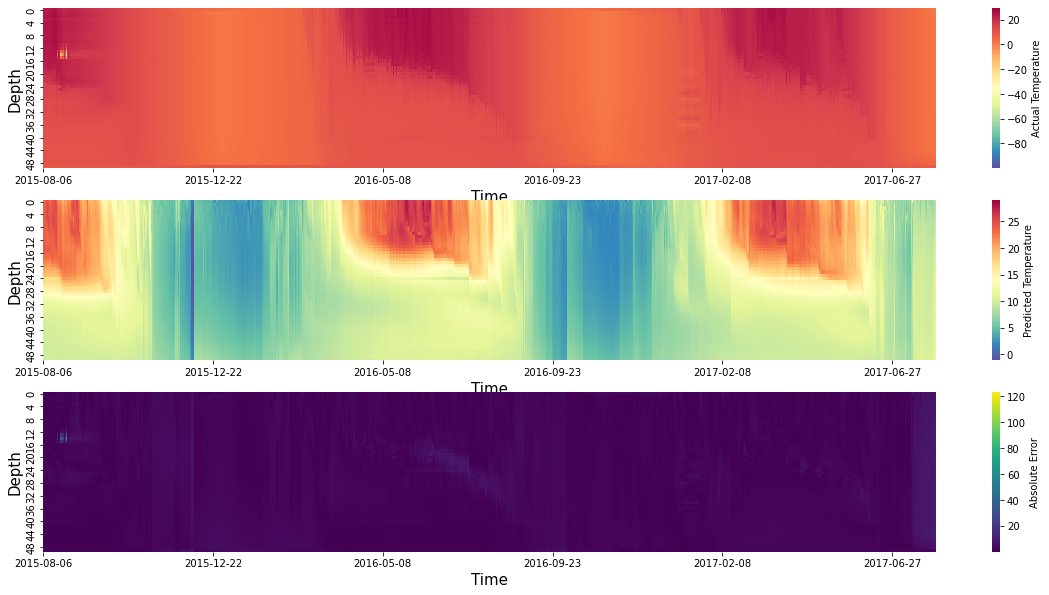

In [55]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))